# **Preprocessing, EDA, and Basic Model Creation**

---
### **Author:** Mark Shumka

### **Contact:** markshumka@gmail.com

### **Date:** November 10, 2023
---

## **Table of Contents** ##
---
1. [Loading and Setup](#1)
2. [Data Enrichment and Preprocessing](#2)
3. [More EDA](#3)
4. [Feature Engineering and Feature Selection](#4)
    - [Goals](#4a)
    - [Shots](#4b)
    - [Expected Goals](#4c)
    - [Days Between Games](#4d)
    - [Distance](#4e)
    - [Other Features](#4f)
5. [Baseline Modeling](#5)
    - [Logistic Regression](#5a)
    - [Decision Tree](#5b)
    - [Support Vector Machine](#5c)
    - [Random Forest](#5d)
    - [XGBoost](#5e)
6. [Refinements (and More Feature Engineering...)](#6)
7. [Next Steps](#7)

## **Loading and Setup** <a class="anchor" id="1"></a>

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import time
import pickle
import os
# Filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [88]:
# Load the dataset
merged_df_copy = pd.read_csv('merged_df_copy.csv')

This is an earlier version of the merged dataset from the previous round of preprocessing. I will explain why I am using this version in the next section.

## **Data Enrichment and Preprocessing** <a class="anchor" id="2"></a>

In the previous round of uploading, cleaning, and exploring the dataset, I merged two datasets that included different years. While one of the datasets included data through the end of the 2022-23 NHL season, the other only went up to the 2019-20 season. As a result, I dropped the last three seasons from the first dataset, and my combined dataset included data only up through three years ago. This bothered me, and I knew there were only five critical columns that I needed from the second dataset, so I investigated where I could that data from. I realized that it was available from the NHL API, so, with much help from the internet, I figured out how to call the API and retrieve that data into a dataframe that I could then merge with my existing dataset.

In [81]:
# import requests tool for calling the API
import requests

# make a GET request to the NHL API
url = "https://statsapi.web.nhl.com/api/v1/schedule?startDate=2016-10-03&endDate=2016-10-20"
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    data = response.json()
else:
    print("Failed to retrieve data from the NHL API")


In [82]:
# create functions to call the API for game and season stats
def get_boxscore_stats(game_id):
    boxscore_url = f"https://statsapi.web.nhl.com/api/v1/game/{game_id}/boxscore"
    response = requests.get(boxscore_url)

    if response.status_code == 200:
        boxscore_data = response.json()
        home_pp_goals = boxscore_data['teams']['home']['teamStats']['teamSkaterStats']['powerPlayGoals']
        away_pp_goals = boxscore_data['teams']['away']['teamStats']['teamSkaterStats']['powerPlayGoals']
        home_pp_opportunities = boxscore_data['teams']['home']['teamStats']['teamSkaterStats']['powerPlayOpportunities']
        away_pp_opportunities = boxscore_data['teams']['away']['teamStats']['teamSkaterStats']['powerPlayOpportunities']
        return home_pp_goals, away_pp_goals, home_pp_opportunities, away_pp_opportunities
    else:
        return None, None, None, None

# List of seasons to fetch data for
seasons = ['20202021', '20212022', '20222023']

game_data = []

for season in seasons:
    url = f"https://statsapi.web.nhl.com/api/v1/schedule?season={season}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
    else:
        print(f"Failed to retrieve data for season {season}")
        continue

    for date in data['dates']:
        for game in date['games']:
            game_id = game['gamePk']
            game_type = game['gameType']

            # Check if it's a regular season game (gameType "R")
            if game_type != "R":
                continue

            game_date = game['gameDate'][:10].replace("-", "")
            home_team_data = game['teams']['home']
            away_team_data = game['teams']['away']

            home_team_name = home_team_data['team']['name']
            home_score = home_team_data['score']
            home_or_away = 1
            won = 1 if home_score > away_team_data['score'] else 0

            # Get power play statistics
            home_pp_goals, away_pp_goals, home_pp_opportunities, away_pp_opportunities = get_boxscore_stats(game_id)

            game_data.append({
                'season': season,
                'game_ID': game_id,
                'gameDate': game_date,
                'team': home_team_name,
                'home_or_away': home_or_away,
                'goals': home_score,
                'goals against': away_team_data['score'],
                'won': won,
                'powerPlayGoals': home_pp_goals,
                'powerPlayOpportunities': home_pp_opportunities
            })

            away_team_name = away_team_data['team']['name']
            away_score = away_team_data['score']
            home_or_away = 0
            won = 1 if away_score > home_score else 0

            game_data.append({
                'season': season,
                'game_ID': game_id,
                'gameDate': game_date,
                'team': away_team_name,
                'home_or_away': home_or_away,
                'goals': away_score,
                'goals against': home_score,
                'won': won,
                'powerPlayGoals': away_pp_goals,
                'powerPlayOpportunities': away_pp_opportunities
            })

# Create a dataframe from the extracted data
missing_seasons_df = pd.DataFrame(game_data)

# Display the dataframe
print(missing_seasons_df)

        season     game_ID  gameDate                   team  home_or_away  \
0     20202021  2020020001  20210113    Philadelphia Flyers             1   
1     20202021  2020020001  20210113    Pittsburgh Penguins             0   
2     20202021  2020020003  20210114    Toronto Maple Leafs             1   
3     20202021  2020020003  20210114     Montréal Canadiens             0   
4     20202021  2020020002  20210114    Tampa Bay Lightning             1   
...        ...         ...       ...                    ...           ...   
6979  20222023  2022021312  20230414   Vegas Golden Knights             0   
6980  20222023  2022020547  20230414  Columbus Blue Jackets             1   
6981  20222023  2022020547  20230414         Buffalo Sabres             0   
6982  20222023  2022020320  20230415    Nashville Predators             1   
6983  20222023  2022020320  20230415     Colorado Avalanche             0   

      goals  goals against  won  powerPlayGoals  powerPlayOpportunities  
0

The team names are written out completely in the API results instead of the abbreviations in the current dataset, so I created a dictionary of team names and abbreviations.

In [ ]:
# dictionary of names, abbreviations
nhl_to_data = {'Anaheim Ducks': 'ANA',
               'Arizona Coyotes': 'ARI',
               'Boston Bruins': 'BOS',
               'Buffalo Sabres': 'BUF',
               'Calgary Flames': 'CGY',
               'Carolina Hurricanes': 'CAR',
               'Chicago Blackhawks': 'CHI',
               'Colorado Avalanche': 'COL',
               'Columbus Blue Jackets': 'CBJ',
               'Dallas Stars': 'DAL',
               'Detroit Red Wings': 'DET',
               'Edmonton Oilers': 'EDM',
               'Florida Panthers': 'FLA',
               'Los Angeles Kings': 'LAK',
               'Minnesota Wild': 'MIN',
               'Montréal Canadiens': 'MTL',
               'Nashville Predators': 'NSH',
               'New Jersey Devils': 'NJD',
               'New York Islanders': 'NYI',
               'New York Rangers': 'NYR',
               'Ottawa Senators': 'OTT',
               'Philadelphia Flyers': 'PHI',
               'Pittsburgh Penguins': 'PIT',
               'San Jose Sharks': 'SJS',
               'Seattle Kraken' : 'SEA',
               'St. Louis Blues': 'STL',
               'Tampa Bay Lightning': 'TBL',
               'Toronto Maple Leafs': 'TOR',
               'Vancouver Canucks': 'VAN',
               'Vegas Golden Knights': 'VGK',
               'Washington Capitals': 'WSH',
               'Winnipeg Jets': 'WPG'}

In [ ]:
#replace Team name with team abbreviation
missing_seasons_df = missing_seasons_df.replace({'team': nhl_to_data})

In [321]:
# review the contents of the new dataframe
missing_seasons_df

,season,game_ID,gameDate,team,home_or_away,goals,goals against,won,powerPlayGoals,powerPlayOpportunities
0,20202021,2020020001,20210113,PHI,home,6,3,True,2,3
1,20202021,2020020001,20210113,PIT,away,3,6,False,1,3
2,20202021,2020020003,20210114,TOR,home,5,4,True,2,4
3,20202021,2020020003,20210114,MTL,away,4,5,False,2,3
4,20202021,2020020002,20210114,TBL,home,5,1,True,2,4
...,...,...,...,...,...,...,...,...,...,...
6979,20222023,2022021312,20230414,VGK,away,3,1,True,0,2
6980,20222023,2022020547,20230414,CBJ,home,2,5,False,0,1
6981,20222023,2022020547,20230414,BUF,away,5,2,True,0,1
6982,20222023,2022020320,20230415,NSH,home,3,4,False,1,2


Now we need to make some adjustments to the columns so that they are consistent with the original dataframe.

In [ ]:
# adjust the season column
missing_seasons_df['season'] = missing_seasons_df['season'].str[:4]

In [87]:
# Convert 'powerPlayGoals' and 'powerPlayOpportunities' columns to integers
missing_seasons_df['powerPlayGoals'] = missing_seasons_df['powerPlayGoals'].astype(int)
missing_seasons_df['powerPlayOpportunities'] = missing_seasons_df['powerPlayOpportunities'].astype(int)

In [ ]:
# Replace values in the 'home_or_away' and 'won' columns
missing_seasons_df['home_or_away'] = missing_seasons_df['home_or_away'].replace({1: 'home', 0: 'away'})
missing_seasons_df['won'] = missing_seasons_df['won'].replace({1: 'TRUE', 0: 'FALSE'})

Or in some cases, we can update the columns in the original dataframe, since we need to make some of them numeric anyway.

In [90]:
# In the 'HoA' column, replace 'home' with 1 and 'away' with 0
merged_df_copy['HoA'] = merged_df_copy['HoA'].replace({'home': 1, 'away': 0})

In [89]:
# Replace 'True' with 1, 'False' with 0, and leave NaN values unchanged
merged_df_copy['won'] = merged_df_copy['won'].replace({'True': 1, 'False': 0}).map({1: 1, 0: 0, np.nan: np.nan})

In [71]:
# confirm the content of the 'won' column
merged_df_copy['won']

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
35339    NaN
35340    NaN
35341    NaN
35342    NaN
35343    NaN
Name: won, Length: 35344, dtype: float64

NaN values are expected at this point because these are the rows of the seasons where only one of my datasets had data. We will be filling in those null values with the newly-downloaded data from the NHL API.

In [92]:
# review the null values in the original dataset
null_value_df = merged_df_copy.isna().sum()

null_value_df.value_counts()

0        109
6984      16
11896      1
7924       1
Name: count, dtype: int64

The 6984 missing values in those columns is good news, because it matches the rows in the newly-created missing_seasons_df above! Those values will fill in all the missing values for the 5 columns we have sourced. First, we need to make some column names consistent between the datasets we are going to merge.

In [93]:
missing_seasons_df = missing_seasons_df.rename(columns={
    'game_ID': 'game_id',
    'home_or_away': 'HoA',
    'goals': 'goals',
    'won': 'won',
    'powerPlayGoals': 'powerPlayGoals',
    'powerPlayOpportunities': 'powerPlayOpportunities'
})

Okay, now we're ready to fill in the new data. We will create a for loop to locate the specific rows in the old dataset that need to be filled, ensuring that we are matching on both gameId and team, since there are two rows with the same gameId for each game.

In [94]:
# Define the columns to fill
columns_to_fill = ['HoA', 'won', 'goals', 'powerPlayOpportunities', 'powerPlayGoals']

# Iterate through each row in merged_df_copy
for index, row in merged_df_copy.iterrows():
    game_id_to_fill = row['gameId']
    team_to_fill = row['team_x']

    # Locate the row in missing_seasons_df that matches the criteria
    matching_row = missing_seasons_df[(missing_seasons_df['game_id'] == game_id_to_fill) & (missing_seasons_df['team'] == team_to_fill)]

    # If a matching row is found, fill the missing values in merged_df_copy
    if not matching_row.empty:
        for col in columns_to_fill:
            merged_df_copy.at[index, col] = matching_row[col].values[0]

Now we can check the null values, and see that the number of columns with 6984 null values has dropped from 16 to 11. We have successfully imported those 5 rows, and now have all the data we need to analyze games through the end of the 2022-23 season!

In [ ]:
null_value_df.value_counts()

We will be looking at the number of days between games as a potential driver of outcome, so before we go any further, we can convert the gameDate column to datetime.

In [144]:
# convert gameDate to datetime
merged_df_copy['gameDate'] = pd.to_datetime(merged_df_copy['gameDate'], format='%Y%m%d')

In [147]:
# save a copy of the new dataset
merged_df_copy.to_csv('merged_data.csv', index=False)

In [191]:
# create a copy of the new dataset we can work with going forward
updated_df = merged_df_copy.copy()

In [98]:
# review the new dataset
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35344 entries, 0 to 35343
Columns: 127 entries, team_x to team_y
dtypes: float64(114), int64(4), object(9)
memory usage: 34.2+ MB


In our original data cleaning exercise, we dropped a number of redundant or not useful columns after merging, so we will do that again.

In [192]:
# drop columns
updated_df = updated_df.drop(columns=['position', 'situation', 'iceTime', 'playoffGame', 'game_id', 'home_or_away', 'settled_in', 'head_coach', 'pim', 'giveaways', 'takeaways', 'blocked', 'shots', 'hits', 'team_y'])

In [150]:
# check for null values
updated_df.isna().sum()

team_x                        0
season                        0
gameId                        0
opposingTeam                  0
gameDate                      0
                          ...  
goals                         0
powerPlayOpportunities        0
powerPlayGoals                0
faceOffWinPercentage      11896
startRinkSide              7924
Length: 112, dtype: int64

In [193]:
# Since that list is long, let's check for null values in each column
columns_with_null = updated_df.columns[updated_df.isna().any()]

# Display columns with null values, if any
if not columns_with_null.empty:
    print("Columns with null values:")
    print(columns_with_null)
else:
    print("No columns have null values.")

Columns with null values:
Index(['team_id', 'faceOffWinPercentage', 'startRinkSide'], dtype='object')


In [194]:
# Drop columns with null values from the DataFrame
updated_df.drop(columns=columns_with_null, inplace=True)

In [404]:
# check for duplicate rows
updated_df.duplicated().sum()

0

In [405]:
# check for duplicate rows
updated_df.T.duplicated().sum()

0

In [195]:
# save the fresh new dataset
updated_df.to_csv('updated_df_data.csv', index=False)

## **More EDA** <a class="anchor" id="3"></a>

The EDA I performed in the previous round was only on the seasons from 2008 to 2020. Now that I have added three additional seasons to the dataset, I want to review some of the previous findings to make sure that they are still valid. First, I will review the likelihood of the home team winning.

In [196]:
# Calculate the winning percentage
winning_percentage = updated_df.groupby('HoA')['won'].mean() * 100
print(winning_percentage)

HoA
0.0    45.659801
1.0    54.340199
Name: won, dtype: float64


The home winning percentage has dropped slightly with the inclusion of the past three seasons of data, from 54.6% to 54.3%. It is worth noting, though, that one of those seasons was the 2020-21 COVID season in which teams were clustered into four geographic regions, and only played the teams within that division. As a result, travel was reduced, potentially reducing the fatigue that players have to overcome when playing an away game. In fact, we see that home winning percentage dropped in that season.

In [197]:
# Calculate the winning percentage for the 2020-21 season
winning_percentage_2020 = updated_df[updated_df['season'] == 2020].groupby('HoA')['won'].mean() * 100
print(winning_percentage_2020)

HoA
0.0    46.658986
1.0    53.341014
Name: won, dtype: float64


Let's graph the new winning percentage findings.

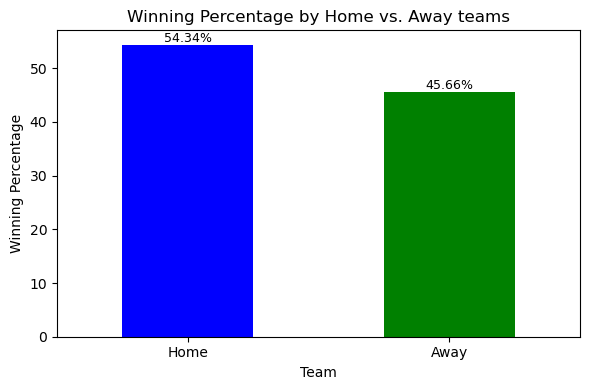

In [198]:
import matplotlib.pyplot as plt

# Sort the data by winning percentage in descending order
sorted_winning_percentage = winning_percentage.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(6, 4))
sorted_winning_percentage.plot(kind='bar', color=['blue', 'green'])

# Set the x-axis labels and the bar values
plt.xticks([0, 1], ['Home', 'Away'], rotation=0)
for i, v in enumerate(sorted_winning_percentage):
    plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontsize=9)

# Customize the plot
plt.title('Winning Percentage by Home vs. Away teams')
plt.xlabel('Team')
plt.ylabel('Winning Percentage')

# Show the plot
plt.tight_layout()
plt.show()

We also looked at the number of wins by team. For completeness, we will update that graph.

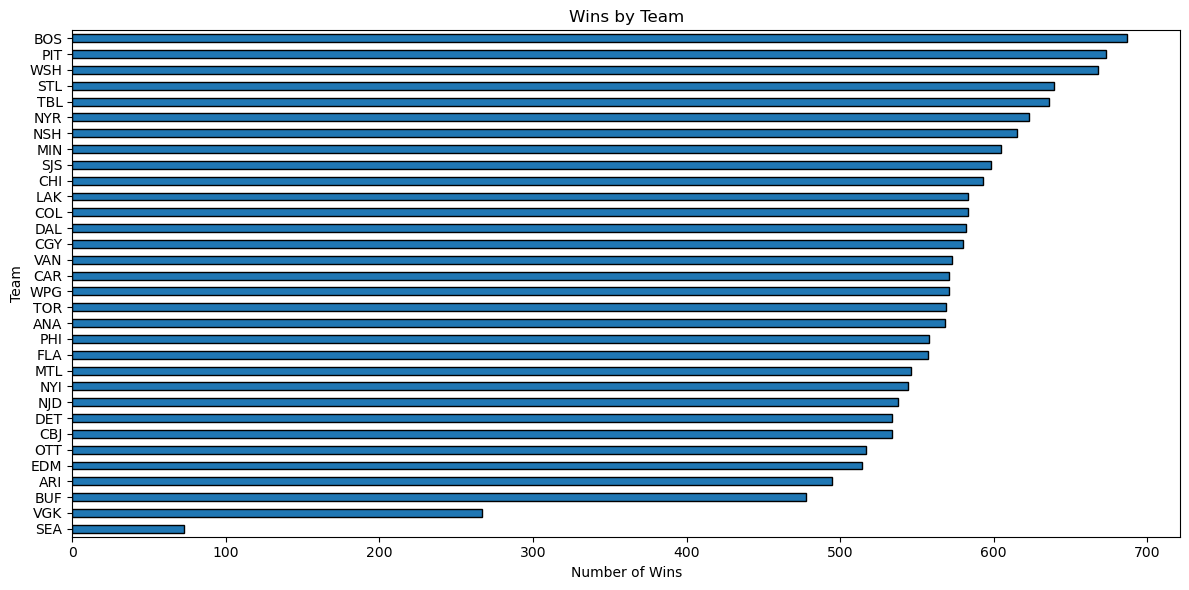

In [199]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'team_x' and count the wins
win_counts = updated_df.groupby('team_x')['won'].sum()

# Combine 'ATL' and 'WPG' into 'WPG'
win_counts['WPG'] = win_counts.get('WPG', 0) + win_counts.get('ATL', 0)
win_counts.drop(['ATL'], inplace=True)  # Drop the 'ATL' entry

# Sort teams by the number of wins in descending order
win_counts = win_counts.sort_values()

# Create a bar chart
plt.figure(figsize=(12, 6))
win_counts.plot(kind='barh', edgecolor='black')

# Set labels and title
plt.xlabel('Number of Wins')
plt.ylabel('Team')
plt.title('Wins by Team')

# Show the plot
plt.tight_layout()
plt.show()


Let's take a look at the distribution of goals per game, as well as the average, overall and for the winning and losing teams.

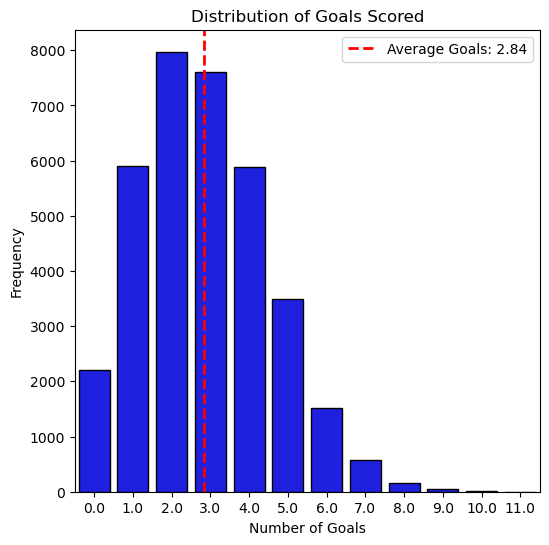

In [200]:
import seaborn as sns

# Create a countplot of goals scored
plt.figure(figsize=(6, 6))
sns.countplot(data=updated_df, x='goals', color='blue', edgecolor='black')

# Calculate and plot the average number of goals scored
average_goals = updated_df['goals'].mean()
plt.axvline(average_goals, color='red', linestyle='dashed', linewidth=2, label=f'Average Goals: {average_goals:.2f}')

# Label the graph
plt.title('Distribution of Goals Scored')
plt.xlabel('Number of Goals')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()


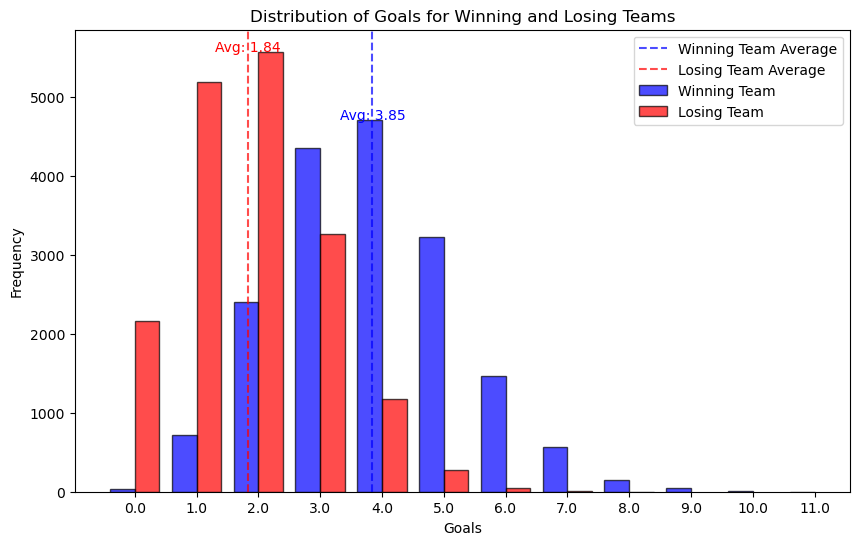

In [201]:
# Filter the dataframe for winning and losing teams
winning_team_goals = updated_df[updated_df['won'] == 1]['goals']
losing_team_goals = updated_df[updated_df['won'] == 0]['goals']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set the width of the bars
width = 0.4

# Calculate the frequency of unique values for winning and losing teams
winning_team_goal_counts = winning_team_goals.value_counts().sort_index()
losing_team_goal_counts = losing_team_goals.value_counts().sort_index()

# Create bar positions for the unique values
winning_team_x = winning_team_goal_counts.index
losing_team_x = losing_team_goal_counts.index

# Create bar plots for winning and losing teams
ax.bar(winning_team_x - width/2, winning_team_goal_counts, width=width, alpha=0.7, label='Winning Team', color='blue', edgecolor='black')
ax.bar(losing_team_x + width/2, losing_team_goal_counts, width=width, alpha=0.7, label='Losing Team', color='red', edgecolor='black')

# Calculate the average goals for winning and losing teams
winning_team_average = winning_team_goals.mean()
losing_team_average = losing_team_goals.mean()

# Add vertical lines for average goals and label the values
ax.axvline(winning_team_average, color='blue', linestyle='--', label='Winning Team Average', alpha=0.7)
ax.axvline(losing_team_average, color='red', linestyle='--', label='Losing Team Average', alpha=0.7)

ax.text(winning_team_average, max(winning_team_goal_counts) + 10, f'Avg: {winning_team_average:.2f}', color='blue', ha='center')
ax.text(losing_team_average, max(losing_team_goal_counts) + 10, f'Avg: {losing_team_average:.2f}', color='red', ha='center')

# Set labels and title
ax.set_xlabel('Goals')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Goals for Winning and Losing Teams')

# Set x-axis ticks and labels
ax.set_xticks(winning_team_x)
ax.set_xticklabels(winning_team_x)

# Add a legend
ax.legend(loc='upper right')

# Show the plot
plt.show()

With the addition of the new seasons, average goals has gone up, indicating an increase in scoring over the past three years. The average goals per team increased from 2.78 to 2.84 per game; winning teams saw a larger increase, from 3.75 to 3.85, than losing teams (1.80 to 1.84). The average margin of victory for the full time period is now slightly over 2 goals.

## **Feature Engineering and Feature Selection** <a class="anchor" id="4"></a>

We still have over 100 variables in our dataset, many of which are components of other variables. In this section, we will review the variables and determine when we need to create engineered variables from them. For example, we have raw data on the shots taken by each team, but there is potentially more insight to be gleaned from combining that data into a single variable that calculates the share of shots taken by each team. Knowing that a team took 30 shots may be valuable in predicting the outcome, but it is likely less valuable than knowing that they took 60% of the total shots in a game. We will also bucket the variables and review them to determine their importance relative to the target variable (win/loss), and discuss whether we should include them in the model going forward.

In [ ]:
# create a new dataframe for feature engineering
engineered_df = updated_df.copy()

### Goals <a class="anchor" id="4a"></a>

The variable with the highest correlation with wins is, not surprisingly, goals scored. Similarly, the variable with the highest negative correlation with wins is goals allowed. It is tempting to create an engineered feature comparing these two variables, but we have to be careful about how we use it. The team with the higher share of goals is going to win every game! Nevertheless, such a feature could be useful if we incorporate performance from past games into a model to predict the outcome of future games. We will therefore create a `goalDifferential` feature, subtracting the opposing team's goals from the team's goals, and a `goalPercentage` feature, which calculates the share of goal each team scored. We will decide which to use, and how to use them, as we proceed to the modeling phase.

In [ ]:
# create goal differential variable
engineered_df['goalDifferential'] = engineered_df['goals'] - engineered_df['goalsAgainst']

In [121]:
# create goal share variable
engineered_df['goalPercentage'] = engineered_df['goals'] / (engineered_df['goals'] + engineered_df['goalsAgainst'])

The `goals` variable incorporates some other columns from the dataset, including reboundGoals and high, medium, and lowDangerGoalsFor. As an example, the sum of high, medium, and lowDangerGoalsFor is the same as the `goals` variable. There are variables for each of the components of `goals` for both teams in the game. `goalsFor` indicates goals for the team whose statistics are contained in that row, while `goalsAgainst` indicates goals for the opposing team. The `goalsFor` for one team will be the same as the `goalsAgainst` for the other team in the same game. The `-For` and `-Against` nomenclature appears throughout the dataset across many different statistics.

Let's look at a heatmap of the `goals` variables to understand their impact on the outcome of the game, as well as their collinearity.

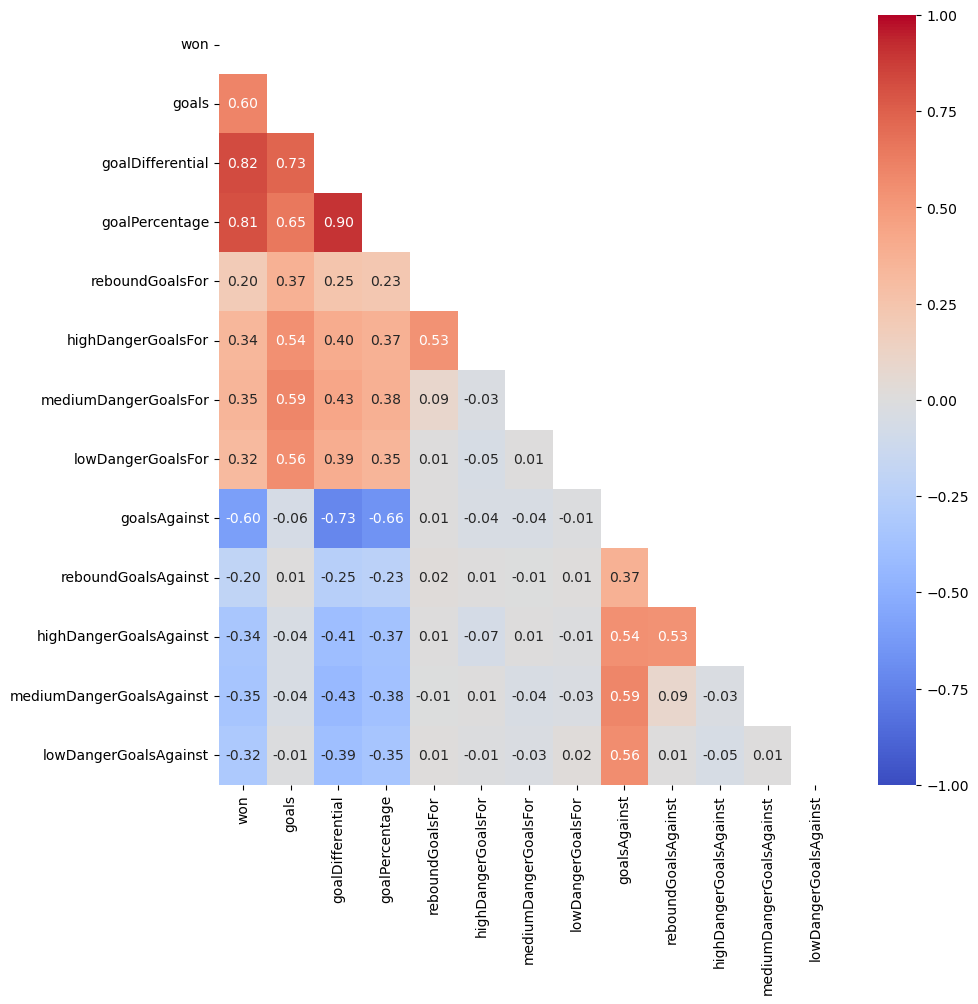

In [122]:
import seaborn as sns

# Create a dataframe including the columns that represent goals data
goals_columns = engineered_df[['won', 'goals', 'goalDifferential', 'goalPercentage','reboundGoalsFor', 'highDangerGoalsFor', 'mediumDangerGoalsFor', 'lowDangerGoalsFor', 'goalsAgainst', 'reboundGoalsAgainst', 'highDangerGoalsAgainst', 'mediumDangerGoalsAgainst', 'lowDangerGoalsAgainst']]

# Calculate the correlation matrix for the selected columns
correlation_matrix = goals_columns.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 10)) 
sns.heatmap(correlation_matrix, center=0, vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt=".2f", mask=mask)
plt.show()


Not surprisingly, `goalDifferential` has the highest correlation with `won`. What is perhaps surprising is that the correlation is not higher, since the goal differential should automatically indicate who won - if the goal differential is positive, the team outscored the opposing team, and vice versa.  `Goals` and `goalsAgainst` have the next highest correlation with `won`, but have a low correlation to each other. The type of goal scored does not seem to affect the outcome, as all types of goals have fairly consistent correlation values. They are, however, highly correlated with overall goals. Therefore, we will initially include only `goals` in our modeling. We will consider adding `goalsAgainst` in any historical data we attempt to incorporate into predicting outcomes, but initially having both `goals` and `goalsAgainst` acts in the same way as having `goalDifferential`, i.e., it gives away the winner.

We will create a dataset for each of the feature buckets to include the initial set of features for modeling.

In [10]:
# create bucket for goals features
goals_features = engineered_df[['goals', 
                               # 'goalsAgainst'
                               ]]

### Shots <a class="anchor" id="4b"></a>

*"You miss 100% of the shots you don't take"* </br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&nbsp;- Wayne Gretzky

Teams can't win if they don't score goals, and they can't score goals if they don't take shots. Our dataset has many statistics relating to shots taken by each team, so we need to understand how they relate to one another, and decide which are most important.

Several Advanced Stats have been created to attempt to consolidate the shot data into a single datapoint. Corsi and Fenwick are the two most well-known.

Corsi is another name for shot attempts. Our dataframe has Corsi percentage.

$\mathbf{\text{Corsi Percentage}} = \dfrac{Shot Attempts For}{Shot Attempts Against}$


$\mathbf{\text{Shot Attempts = Unblocked Shot Attempts + Blocked Shots}}$

Fenwick is similar, but does not include blocked shots in its calculation.

$\mathbf{\text{Unblocked Shot Attempts For = Shots on Goal + Missed Shots}}$

Shots on Goal includes Rebound Shots.

Since we have the raw data for each of those statistics for each team, Corsi effectively captures the information from eleven other columns in a single value. We will attempt to validate whether it is a more effective predictor of outcome than any of the other values (and Fenwick). Before we do that, let's create a separate Shot Percentage value, comparing shots on goal for to shots on goal against. I am proposing this because it is not clear that blocked and missed shots contribute to goals, but shots on goal do.

In [ ]:
# create shots percentage variable
engineered_df['ShotsPercentage'] = engineered_df['shotsOnGoalFor'] / (engineered_df['shotsOnGoalFor'] + engineered_df['shotsOnGoalAgainst'])

Shots are also as low-, medium-, and high-danger, depending on the probability of shots of that type from that location resulting in goals. We saw the danger-based metrics in the goals section above. We will create two variables to measure how these shots affect game outcomes: one to measure the share of high-danger shots for the team, and one to measure high-danger shots as a percent of total shots for the team. The idea is that the team with the most high-danger shots is more likely to win, while a lower percent of high-danger shots would indicate that while they may have quantity of shots, they lack quality. This is a sub-area of Advanced Stats that focuses on Chances.

In [ ]:
# create high danger shots variables
engineered_df['highDangerShotsShare'] = engineered_df['highDangerShotsFor'] / (engineered_df['highDangerShotsFor'] + engineered_df['highDangerShotsAgainst'])

engineered_df['highDangerShotsRatio'] = engineered_df['highDangerShotsFor'] / (engineered_df['highDangerShotsFor'] + engineered_df['mediumDangerShotsFor'] + engineered_df['lowDangerShotsFor'])

We will also create a shooting percentage variable, which calculates the percent of shots on goal that result in goals. A high volume of shots won't lead to wins if very few of them result in goals.

In [ ]:
# shooting percentage variable
engineered_df['ShootingPercentage'] = engineered_df['goals'] / engineered_df['shotsOnGoalFor']

While we're at it, let's create a save percentage variable, which is the percent of the opposing team's shots on goal that the goalie saves. It's the inverse of the opposing team's shooting percentage.

In [ ]:
# save percentage variable
engineered_df['SavePercentage'] = (engineered_df['shotsOnGoalAgainst'] - engineered_df['goalsAgainst']) / engineered_df['shotsOnGoalAgainst']

Now we can look at a heatmap of the shots variables.

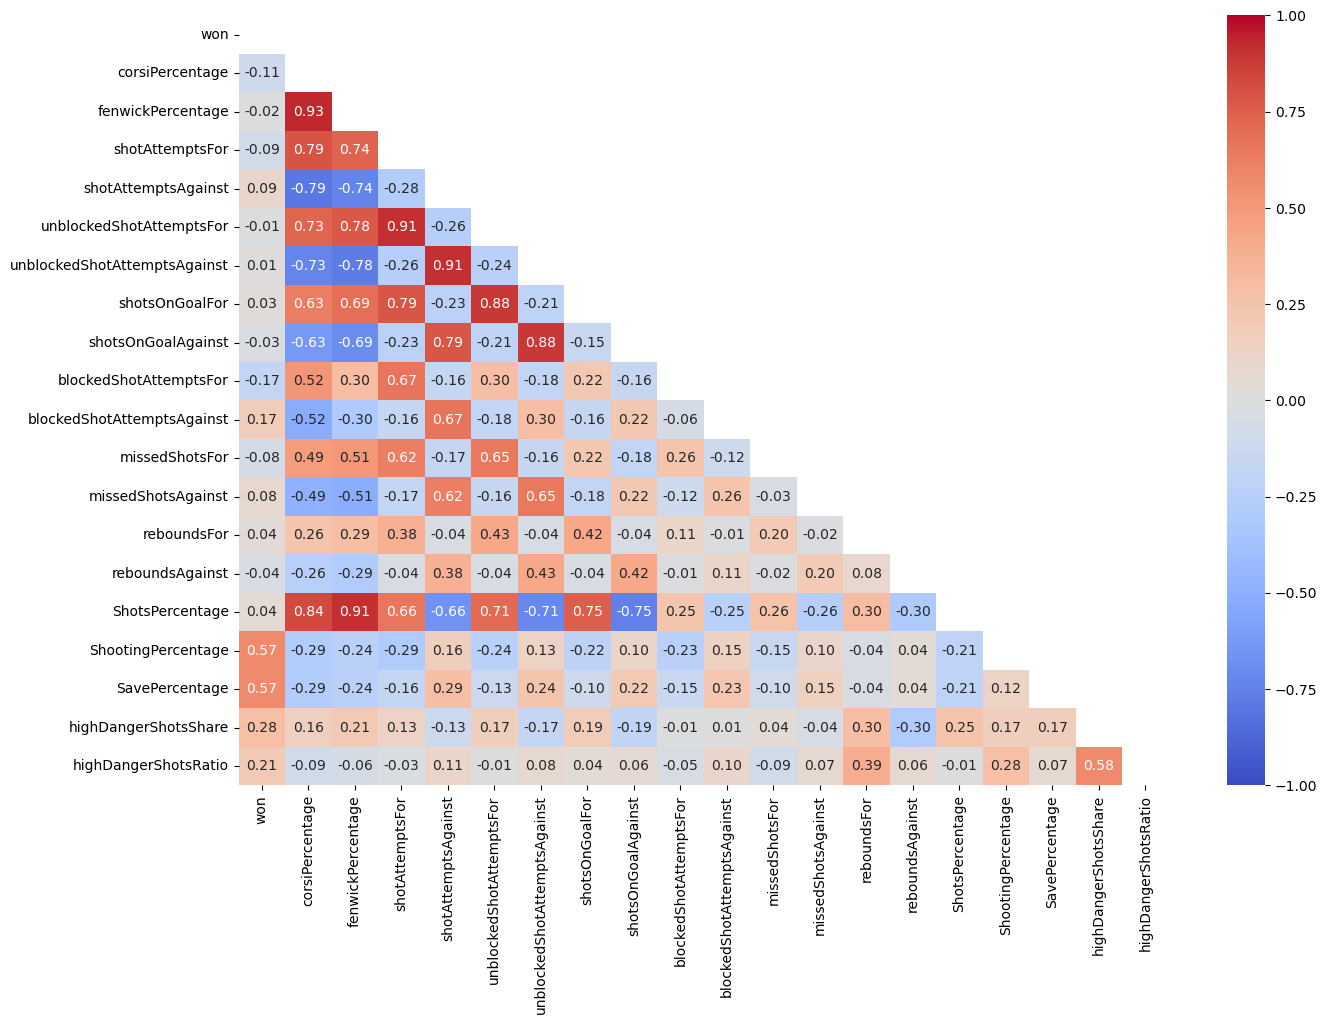

In [11]:
# Create a dataframe including the columns that represent shots data
shots_columns = engineered_df[['won', 'corsiPercentage', 'fenwickPercentage', 'shotAttemptsFor', 'shotAttemptsAgainst', 'unblockedShotAttemptsFor', 'unblockedShotAttemptsAgainst', 'shotsOnGoalFor', 'shotsOnGoalAgainst', 'blockedShotAttemptsFor', 'blockedShotAttemptsAgainst', 'missedShotsFor', 'missedShotsAgainst', 'reboundsFor', 'reboundsAgainst', 'ShotsPercentage', 'ShootingPercentage', 'SavePercentage', 'highDangerShotsShare', 'highDangerShotsRatio']]

# Calculate the correlation matrix for the selected columns
correlation_matrix_shots = shots_columns.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_shots, dtype=bool))

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(15, 10)) 
sns.heatmap(correlation_matrix_shots, center=0, vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt=".2f", mask=mask)
plt.show()


Some interesting stuff in there. Corsi looks like it has a higher impact on outcome than Fenwick, but they both have a negative impact on likelihood of winning. This is counterintuitive because by capturing all of the shot attempts and comparing them to the other teams as a percent of total, it is intended to capture both offensive pressure and puck possessions, two things that are thought of as critical to winning the game. One possible explanation is that teams that get a lead do not need to take as many shots, while those that are trailing increase their urgency and intensity and begin taking more shots from anywhere. This is supported by the simple `ShotsPercentage` variable, which is only slightly positively correlated with wins, while `highDangerShotsShare` and `highDangerShotsRatio` are both much higher. This indicates that isn't so much the quantity of shots that leads to victory as the quality. 

Of all of the variables, though, `ShootingPercentage` and `SavePercentage` are the most highly correlated with wins. This makes sense, as you are more likely to win if a higher percent of your team's shots goes in than the other team's. Interestingly, though, these two variables are not particularly correlated with each other.

Interestingly, blocked shots seems to have a moderate impact on winning. We will create a `blocksPercentage` variable to measure the relative number of blocks for each team. We will include it in a separate bucket of variables, though, because it is more related to defence than to shots.

In [ ]:
# create blocks percentage variable
engineered_df['blocksPercentage'] = engineered_df['blockedShotAttemptsAgainst'] / (engineered_df['blockedShotAttemptsFor'] + engineered_df['blockedShotAttemptsAgainst'])

Based on the analysis above, we will include the following six variables in our initial bucket of shots features.

In [11]:
shots_features = engineered_df[['corsiPercentage', 
                                'ShotsPercentage', 
                                'ShootingPercentage', 
                                'SavePercentage',
                                'highDangerShotsShare',
                                'highDangerShotsRatio'
                               ]]

### Expected Goals <a class="anchor" id="4c"></a>

Expected Goals (xGoals) is where Advanced Stats models do a lot of heavy lifting. These models gather data on goal-scoring opportunites, i.e. attempted shots, and calculate a probability of scoring based on a number of factors, including the distance from the net, angle of the shot, type of shot, and what happened before the shot. There are obviously outcomes of shot attempts other than goals, and that data is also captured. The following is a partial list of variables generated by these models:

- xGoalsFor
- xGoalsAgainst
- xGoalsPercentage
- xOnGoalFor (expected shots on goal)
- xReboundsFor
- xFreezeFor
- xPlayStoppedFor
- xPlayContinuedInZoneFor
- xPlayContinuedOutsideZoneFor
- lowDangerxGoalsFor
- mediumDangerxGoalsFor
- highDangerxGoalsFor

...along with the corresponding 'Against' values, i.e, the equivalent statistics for the other team. We are most likely only interested in the xGoalsFor and Against (and percentage), because everything else represents the inverse. That is, if we do not expect a shot attempt to result in a goal, we expect it to result in one of the other outcomes. In addition, the low, medium, and highDangerxGoalsFor are subsets of the overall xGoalsFor.

Different Advanced Stats sites have different formulas for calculating xGoals. We are using the values from [Moneypuck.com](moneypuck.com). The site also has some adjusted versions of xGoals, including flurryAdjustedxGoals, which discounts the expected goal value of the 2nd, 3rd, 4th, etc. shots in a flurry of shots. These shots are discounted because they only had the opportunity to occur because the team did not score on a previous shot. They also have a stat called scoreVenueAdjustedxGoals which gives more credit to away teams and teams with large leads when they get an xGoal. In addition, they combine those two stats into flurryScoreVenueAdjustedxGoalsFor. We will create percentage variables based on those, to see if combining some of these elements improves predictions.

In [ ]:
# create adjusted xGoals variables
engineered_df['flurryPercentage'] = engineered_df['flurryAdjustedxGoalsFor'] / (engineered_df['flurryAdjustedxGoalsFor'] + engineered_df['flurryAdjustedxGoalsAgainst'])

engineered_df['scoreVenuePercentage'] = engineered_df['scoreVenueAdjustedxGoalsFor'] / (engineered_df['scoreVenueAdjustedxGoalsFor'] + engineered_df['scoreVenueAdjustedxGoalsAgainst'])

engineered_df['FSVxGoalsPercentage'] = engineered_df['flurryScoreVenueAdjustedxGoalsFor'] / (engineered_df['flurryScoreVenueAdjustedxGoalsFor'] + engineered_df['flurryScoreVenueAdjustedxGoalsAgainst'])

We can also create a metric called `shotEfficiency` which measures actual goals divided by expected goals, as well as the defensive equivalent, `defensiveEfficiency` which measures actual goals against divided by expected goals against. 

In [4]:
# create efficiency variables
engineered_df['shotEfficiency'] = engineered_df['goals'] / engineered_df['xGoalsFor']
engineered_df['defensiveEfficiency'] = engineered_df['goalsAgainst'] / engineered_df['xGoalsAgainst']

Time for a heatmap.

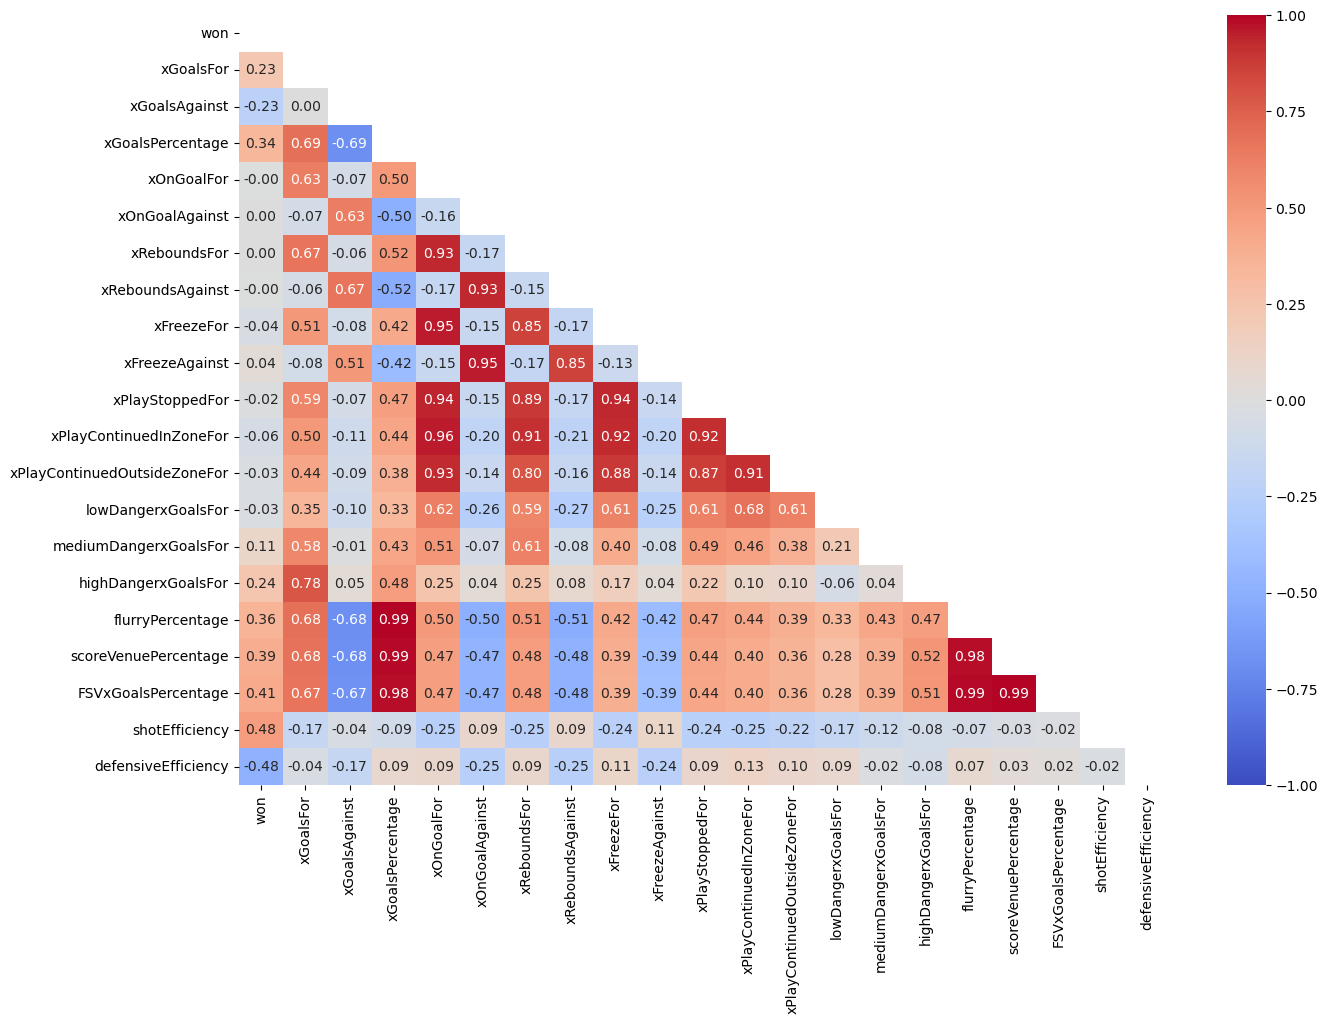

In [5]:
# Create a dataframe including the columns that represent xGoals data
xGoals_columns = engineered_df[['won', 
                                'xGoalsFor', 
                                'xGoalsAgainst', 
                                'xGoalsPercentage', 
                                'xOnGoalFor', 
                                'xOnGoalAgainst', 
                                'xReboundsFor',
                                'xReboundsAgainst', 
                                'xFreezeFor', 
                                'xFreezeAgainst', 
                                'xPlayStoppedFor', 
                                'xPlayContinuedInZoneFor', 
                                'xPlayContinuedOutsideZoneFor', 
                                'lowDangerxGoalsFor', 
                                'mediumDangerxGoalsFor', 
                                'highDangerxGoalsFor', 
                                'flurryPercentage', 
                                'scoreVenuePercentage', 
                                'FSVxGoalsPercentage',
                                'shotEfficiency',
                                'defensiveEfficiency'
                               ]]

# Calculate the correlation matrix for the selected columns
correlation_matrix_xGoals = xGoals_columns.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_xGoals, dtype=bool))

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(15, 10)) 
sns.heatmap(correlation_matrix_xGoals, center=0, vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt=".2f", mask=mask)
plt.show()

As expected, we do not see much of an impact on outcome from the expected "non-goal" variables, so we can exclude them. The question then becomes which expected goal variable(s) to include. There is much collinearity among the different xGoals variables, so we will have to limit the number we include. `xGoalsPercentage` has a large correlation with wins, and the adjusted versions (flurry, score/venue, and FSV) have even higher correlations. We also see a high correlation value with wins in both `shotEfficiency` and `defensiveEfficiency`, neither of which have particularly strong correlations with other shot variables, or each other. 

In [6]:
# create xGoals bucket
xGoals_features = engineered_df[['xGoalsPercentage', 
                                 'FSVxGoalsPercentage',
                                 'shotEfficiency',
                                 'defensiveEfficiency'
                                ]]

### Days Between Games <a class="anchor" id="4d"></a>

Coming into this analysis, one of my hypotheses was that the number of days a team has between games has an impact on the outcome. The idea is that with more rest between games, teams can play with more energy, and they can also use the days off to practice and improve on any issues they have been having. It is widely understood that teams that have to play on back-to-back days are more likely to lose the second game than when they have days in between, so I wanted to confirm that understanding and analyze whether and how much it extends to additional days between games. I started by creating a variable to capture the date of the previous game played, then subtracted that from the date of the current game to determine days since last game (hence the need to convert gameDate to datetime above). From there, I created a variable to identify if the game was the second game of back-to-back games, i.e., if there was only one day between games.

In [ ]:
# to get days since last game and back-to-back
updated_df['Last_Game_Date'] = updated_df.groupby('team_x')['gameDate'].shift()
updated_df['Days_Since_Last_Game'] = updated_df['gameDate'] - updated_df['Last_Game_Date']
updated_df['back_to_back'] = np.where(updated_df['Days_Since_Last_Game'] == '1 days', 1, 0)

In [203]:
updated_df

,team_x,season,gameId,opposingTeam,gameDate,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalFor,xGoalsFor,...,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,HoA,won,goals,powerPlayOpportunities,powerPlayGoals,Last_Game_Date,Days_Since_Last_Game,back_to_back
0,NYR,2008,2008020001,TBL,2008-10-04,0.4596,0.6408,0.6310,37.733,2.287,...,2.833,2.714,0.0,1.0,2.0,7.0,1.0,NaT,NaT,0
1,NYR,2008,2008020003,TBL,2008-10-05,0.6619,0.6207,0.6190,34.277,1.793,...,1.117,1.091,1.0,1.0,2.0,4.0,1.0,2008-10-04,1 days,1
2,NYR,2008,2008020010,CHI,2008-10-10,0.4123,0.4904,0.4643,27.924,1.938,...,2.751,2.730,1.0,1.0,4.0,3.0,0.0,2008-10-05,5 days,0
3,NYR,2008,2008020019,PHI,2008-10-11,0.5008,0.5000,0.4810,27.100,3.030,...,2.958,2.907,0.0,1.0,4.0,6.0,1.0,2008-10-10,1 days,1
4,NYR,2008,2008020034,NJD,2008-10-13,0.3114,0.4369,0.4507,21.917,1.562,...,2.691,2.242,1.0,1.0,4.0,4.0,2.0,2008-10-11,2 days,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35339,LAK,2020,2020020852,COL,2021-05-07,0.3439,0.2990,0.3000,15.565,1.480,...,3.204,3.106,1.0,0.0,2.0,1.0,0.0,2021-05-05,2 days,0
35340,LAK,2020,2020020867,COL,2021-05-08,0.3911,0.4624,0.4412,21.386,1.477,...,2.438,2.396,1.0,0.0,2.0,2.0,0.0,2021-05-07,1 days,1
35341,LAK,2020,2020020456,STL,2021-05-10,0.4096,0.5556,0.5758,26.226,1.735,...,2.803,2.495,1.0,0.0,1.0,2.0,0.0,2021-05-08,2 days,0
35342,LAK,2020,2020020688,COL,2021-05-12,0.1459,0.3761,0.3210,17.798,0.760,...,4.181,3.998,0.0,0.0,0.0,2.0,0.0,2021-05-10,2 days,0


In [165]:
# count the number of `back_to_back` games
updated_df['back_to_back'].sum()

6076

Let's take a look at the number of days between games, and the frequency with which that gap occurs.

In [168]:
# Set the maximum number of rows to display (replace 109 with the number of unique values you have)
pd.set_option('display.max_rows', 109)

# Print the value counts
print(updated_df['Days_Since_Last_Game'].value_counts())

Days_Since_Last_Game
2 days        19393
3 days         6493
1 days         6076
4 days         1663
5 days          583
6 days          213
7 days          138
180 days         80
179 days         60
10 days          55
9 days           46
181 days         39
8 days           34
287 days         26
11 days          25
182 days         23
17 days          22
159 days         20
187 days         17
12 days          17
19 days          15
16 days          15
167 days         12
166 days         12
173 days         11
178 days         11
309 days         11
157 days         11
175 days         11
20 days          10
18 days          10
158 days          9
186 days          8
14 days           7
310 days          7
-12 days          5
13 days           5
308 days          4
15 days           4
288 days          4
155 days          4
160 days          4
174 days          4
311 days          4
312 days          3
189 days          3
165 days          3
161 days          3
152 days          2

There are some high positive and some negative values in this list. The high positive ones include the first game of each season, which is calculating the days since the last game of the prior season. There are also multiple occurrences of negative days between games, which I did not anticipate. After some investigation, I discovered that many of these games were postponed, typically due to bad weather. They were played at a later date, typically months later, but retained their gameId in the original order. For example, Carolina played a game on 2016-12-17, and had another game scheduled for the 2016-12-20. That game was postponed until 2017-03-27, so it looks like there were 100 days between games. Then the following game, which is the next one in the numerically-ordered season schedule, took place on 2016-12-22, so the formula calculates that there were -95 days between those two games. 

Both the high and negative numbers do not make sense for analysis, but there is no programmatic way to to adjust the calculations to account for them. They represent ~1.9% of games, but over 80% of those are after the long breaks between seasons. We will replace values greater than 10 and less than 0 with the category average. In each case they are playing these games after a relatively low number of days, given that each first game of the season follows exhibition games, which we aren't including in our analysis.

In [205]:
# Convert 'Days_Since_Last_Game' to numeric (in days) using .dt.days
updated_df['Days_Since_Last_Game'] = updated_df['Days_Since_Last_Game'].dt.days

In [208]:
# Calculate the mean while excluding values greater than 10 and less than 0
mean_days_since_last_game_filtered = updated_df[(updated_df['Days_Since_Last_Game'] >= 0) & (updated_df['Days_Since_Last_Game'] <= 10)]['Days_Since_Last_Game'].mean()

print(mean_days_since_last_game_filtered)

2.2305874214561596


In [209]:
# Replace values greater than 10, negative values, and missing values with the mean
def replace_with_mean(x):
    if pd.notna(x) and (x > 10 or x < 0):
        return mean_days_since_last_game_filtered
    return x

updated_df['Days_Since_Last_Game'] = updated_df['Days_Since_Last_Game'].apply(replace_with_mean)


In [210]:
# Print the value counts
print(updated_df['Days_Since_Last_Game'].value_counts())

Days_Since_Last_Game
2.000000     19393
3.000000      6493
1.000000      6076
4.000000      1663
2.230587       617
5.000000       583
6.000000       213
7.000000       138
10.000000       55
9.000000        46
8.000000        34
Name: count, dtype: int64


Next, we will take a look at the games played the day after the previous games, what we have called the `back_to_back` category. We are interested in understanding how much of an impact that has on likelihood of winning. As a reminder, the percent of games won across the entire dataset is obviously 50%, as every game has a winner and a loser.

In [103]:
# Filter include rows where 'back_to_back' is 1
back_to_back_1_df = updated_df[updated_df['back_to_back'] == 1]

# Calculate the percentage of 1s and 0s in the 'won' column
percent_won_1 = (back_to_back_1_df['won'] == 1).mean() * 100
percent_won_0 = (back_to_back_1_df['won'] == 0).mean() * 100

print(f"Percentage of `back_to_back` games won: {percent_won_1:.2f}%")
print(f"Percentage of `back_to_back` games lost: {percent_won_0:.2f}%")

Percentage of `back_to_back` games won: 45.08%
Percentage of `back_to_back` games lost: 54.92%


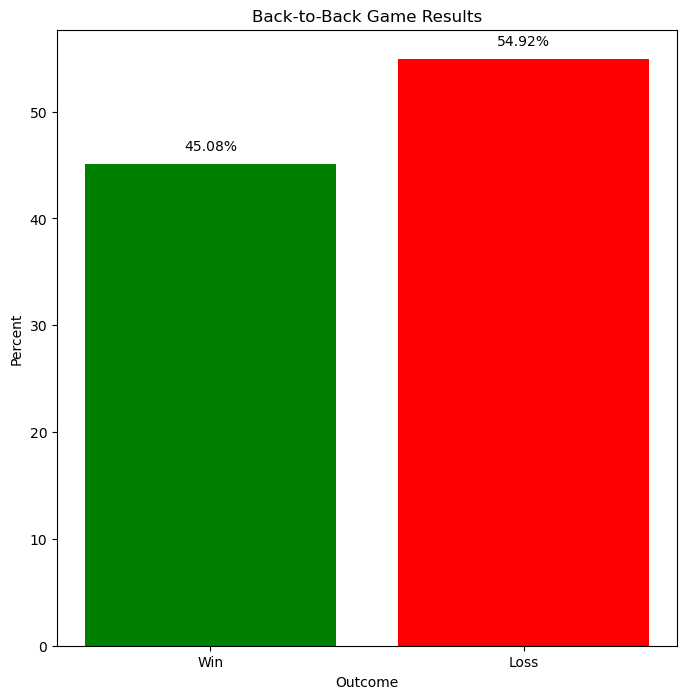

In [109]:
# Data
results = ['Win', 'Loss']
percentages = [percent_won_1, percent_won_0]

# Create a bar graph
plt.figure(figsize=(8, 8))
plt.bar(results, percentages, color=['green', 'red'])

# Add titles and labels
plt.title('Back-to-Back Game Results')
plt.xlabel('Outcome')
plt.ylabel('Percent')

# Add values above the bars
for i, v in enumerate(percentages):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom')

# Show the graph
plt.show()

The conventional wisdom is true. Having to play games on consecutive days has a significant downward impact on likelihood of winning, dropping the team's winning percentage to 45%. A team facing an opponent that played the previous day automatically sees their chances of winning the game increased, a fact that is very useful in predicting the outcome of such games.

Now let's take a look and understand if that effect is limited to back-to-back games, or if it extends beyond. That is, does the likelihood of winning continue to increase as the number of days between games increases? Before we continue the analysis, there remain some null values in the `Days_Since_Last_Game` column. These are the first games in the dataset for each of the teams, as there is no previous game. Since these are also the first games of a season, we can replace them with a value of 10.

In [183]:
updated_df.isna().sum()

team_x                     0
season                     0
gameId                     0
opposingTeam               0
gameDate                   0
                          ..
powerPlayOpportunities     0
powerPlayGoals             0
Last_Game_Date            33
Days_Since_Last_Game      33
back_to_back               0
Length: 112, dtype: int64

In [ ]:
# fill null values
updated_df['Days_Since_Last_Game'].fillna(10, inplace=True)

Okay, now that we have those values taken care of, we can graph the winning percentage based on the days since the last game.

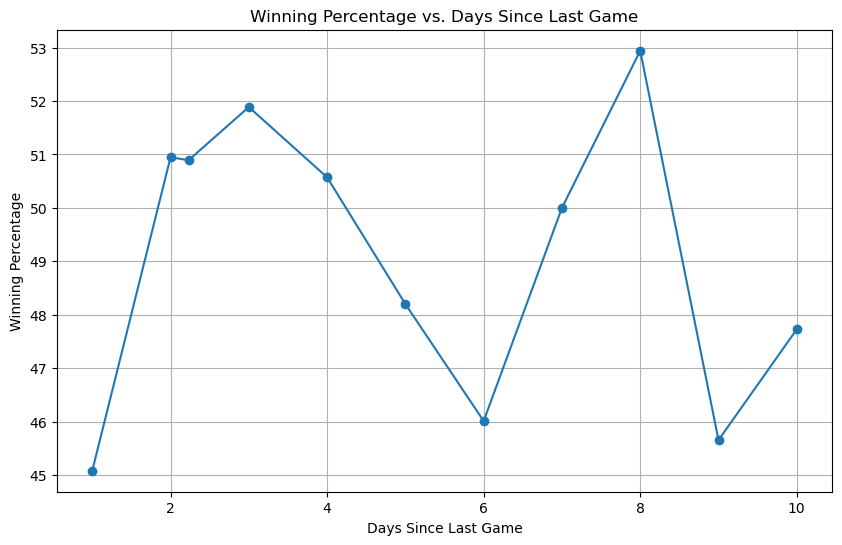

In [213]:
import matplotlib.pyplot as plt

# Filter the data for 'Days_Since_Last_Game' values from 0 to 8
filtered_data = updated_df[updated_df['Days_Since_Last_Game'].between(1, 10)]

# Calculate the average winning percentage for each 'Days_Since_Last_Game'
average_winning_percentage = filtered_data.groupby('Days_Since_Last_Game')['won'].mean() * 100

# Create a line graph
plt.figure(figsize=(10, 6))
plt.plot(average_winning_percentage.index, average_winning_percentage.values, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Days Since Last Game')
plt.ylabel('Winning Percentage')
plt.title('Winning Percentage vs. Days Since Last Game')

# Show the plot
plt.grid(True)
plt.show()

The hypothesis that more days between games leads to a higher winning percentage only holds partially. One day off between games is better than zero, and two days is better than one. After that, there doesn't appear to be a positive relationship between days off and winning percentage. This may be due to the small sample size making it difficult to draw meaningful conclusions, as over 90% of games happen 1, 2, or 3 days after the prior one. Nevertheless playing again the day after the previous game is a clear disadvantage. 

### Distance <a class="anchor" id="4e"></a>

The other hypothesis that I had coming into this analysis is that distance traveled between games has an impact on outcome. We have already seen that the home team has an advantage, winning over 54% of the games. Does the distance that the visiting team had to travel have an impact? Not all away games are created equal. For example, the New York Rangers have to travel 15 kms to play a road game against the New Jersey Devils, but the Vancouver Canucks have to travel more than 4,400 kms to play a road game against the Florida Panthers, yet there is no distinction between these games in the data. In order to test the impact of travel, I needed a way to calculate the distance between the location of the prior game and the current game. I found a dataset that included all of the teams and the distance between their home arenas.

In [53]:
# Load the distance matrix from the CSV file
distance_matrix = pd.read_csv('nhl_team_distance_data_edited.csv', index_col=0)

In [54]:
# display the distance matrix
distance_matrix

,ANA,ARI,BOS,BUF,CGY,CAR,CHI,COL,CBJ,DAL,...,SJS,SEA,STL,TBL,TOR,VAN,VGK,WSH,WPG,ATL
ANA,NaN,612.86,4233.66,3594.23,1955.31,3647.26,2852.43,1398.51,3239.99,2050.02,...,477.91,1563.35,2616.32,3518.22,3558.82,1755.15,582.02,3757.68,2519.75,3091.0
ARI,612.86,NaN,3704.53,3072.68,1951.97,3062.76,2331.11,946.27,2689.49,1439.29,...,969.59,1780.08,2055.98,2905.37,3046.59,1966.14,572.19,3196.82,2200.88,2571.0
BOS,4233.66,3704.53,NaN,641.64,3363.94,983.85,1381.23,2842.04,1033.70,2493.25,...,4311.10,4000.79,1667.04,1905.03,690.73,4023.05,3732.53,633.43,2163.07,1507.0
BUF,3594.23,3072.68,641.64,NaN,2788.75,786.45,742.89,2200.91,472.07,1926.74,...,3670.10,3398.68,1063.39,1691.27,94.64,3433.89,3090.89,468.87,1597.79,1122.0
CGY,1955.31,1951.97,3363.94,2788.75,NaN,3272.73,2235.78,1437.85,2687.10,2467.03,...,1645.16,710.82,2315.42,3683.25,2710.22,673.71,1441.02,3167.49,1200.88,3073.0
CAR,3647.26,3062.76,983.85,786.45,3272.73,NaN,1037.24,2342.70,596.44,1692.44,...,3826.12,3794.61,1063.14,942.12,873.57,3865.86,3228.79,375.51,2158.71,572.0
CHI,2852.43,2331.11,1381.23,742.89,2235.78,1037.24,NaN,1462.81,457.09,1284.02,...,2942.92,2775.82,414.26,1624.48,716.38,2837.55,2357.47,972.34,1144.51,946.0
COL,1398.51,946.27,2842.04,2200.91,1437.85,2342.70,1462.81,NaN,1873.33,1066.12,...,1491.28,1641.17,1280.58,2451.28,2162.35,1776.45,898.13,2399.40,1285.59,1951.0
CBJ,3239.99,2689.49,1033.70,472.07,2687.10,596.44,457.09,1873.33,NaN,1468.50,...,3363.57,3232.86,636.79,1338.26,507.10,3294.14,2771.42,527.51,1562.27,701.0
DAL,2050.02,1439.29,2493.25,1926.74,2467.03,1692.44,1284.02,1066.12,1468.50,NaN,...,2331.47,2703.64,881.00,1477.63,1936.12,2842.37,1761.93,1903.73,1901.88,1160.0


Armed with that, I could create a function to calculate the distance between the prior game and the current game. I needed to make sure that it calculated the distance between consecutive home games as 0, and the expectation was that teams would fare best when that distance was 0, as it meant the team did not have to travel at all between games.

In [218]:
# Create a DataFrame to store the distances
distances_df = pd.DataFrame(columns=updated_df.columns)

# Create a location column
updated_df['Location'] = updated_df.apply(lambda row: row['team_x'] if row['HoA'] == 1 else row['opposingTeam'], axis=1)

# Function to calculate distance
def calculate_distance(row):
    if pd.notna(row['Last_Game_Date']):
        # Get the location of the previous game from the 'Last_Game_Date'
        last_game_location = updated_df.loc[updated_df['gameDate'] == row['Last_Game_Date'], 'Location'].values[0]

        # Determine the current game location
        current_location = row['Location']

        if last_game_location == current_location:
            # The locations are the same, set distance to 0
            return 0.0
        else:
           # Calculate the distance based on the previous and current locations
           distance = distance_matrix.at[last_game_location, current_location]
           return distance
           
    else:
        # If there's no information about the last game, set distance to NaN
        return 0.0

# Create the 'Distance_Since_Last_Game' column based on the 'Location' values
updated_df['Distance_Since_Last_Game'] = updated_df.apply(calculate_distance, axis=1)

In [219]:
updated_df.head()

,team_x,season,gameId,opposingTeam,gameDate,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalFor,xGoalsFor,...,HoA,won,goals,powerPlayOpportunities,powerPlayGoals,Last_Game_Date,Days_Since_Last_Game,back_to_back,Location,Distance_Since_Last_Game
0,NYR,2008,2008020001,TBL,2008-10-04,0.4596,0.6408,0.6310,37.733,2.287,...,0.0,1.0,2.0,7.0,1.0,NaT,10.0,0,TBL,0.00
1,NYR,2008,2008020003,TBL,2008-10-05,0.6619,0.6207,0.6190,34.277,1.793,...,1.0,1.0,2.0,4.0,1.0,2008-10-04,1.0,1,NYR,1620.13
2,NYR,2008,2008020010,CHI,2008-10-10,0.4123,0.4904,0.4643,27.924,1.938,...,1.0,1.0,4.0,3.0,0.0,2008-10-05,5.0,0,NYR,0.00
3,NYR,2008,2008020019,PHI,2008-10-11,0.5008,0.5000,0.4810,27.100,3.030,...,0.0,1.0,4.0,6.0,1.0,2008-10-10,1.0,1,PHI,137.47
4,NYR,2008,2008020034,NJD,2008-10-13,0.3114,0.4369,0.4507,21.917,1.562,...,1.0,1.0,4.0,4.0,2.0,2008-10-11,2.0,0,NYR,137.47


Spoiler Alert: As you will see from heatmap several sections below, there is virtually no correlation between distance since last game and likelihood of winning. Not willing to completely abandon the idea, I decided to create another variable that combines distance traveled and days since last game. The thinking is that it is a disadvantage if the team has to play shortly after traveling a long distance, versus having time to settle in. So I created a variable to look at distance traveled per day between games. I then created a graph showing the distribution of distances traveled per day and the winning percentage for each of the bins in that distribution.

In [ ]:
# create distance per day variable
updated_df['Distance_per_day'] = updated_df['Distance_Since_Last_Game'] / updated_df['Days_Since_Last_Game']

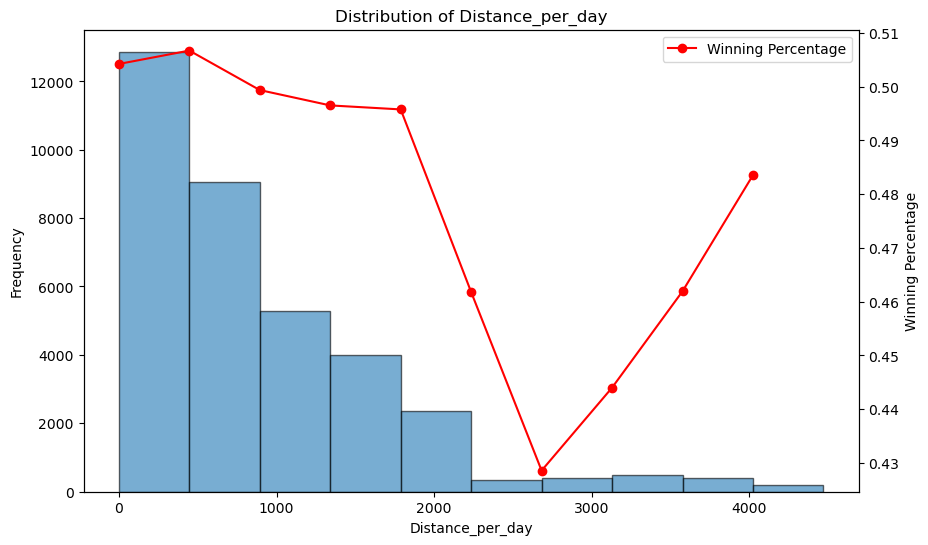

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Create a histogram of 'Distance_per_day'
plt.figure(figsize=(10, 6))
plt.hist(engineered_df['Distance_per_day'], bins=10, edgecolor='k', alpha=0.6, label='Distance_per_day')
plt.xlabel('Distance_per_day')
plt.ylabel('Frequency')
plt.title('Distribution of Distance_per_day')

# Calculate the mean value of 'won' for each bin
bin_means = []
bin_edges = np.histogram(engineered_df['Distance_per_day'], bins=10)[1]
for i in range(1, len(bin_edges)):
    mask = (engineered_df['Distance_per_day'] >= bin_edges[i - 1]) & (engineered_df['Distance_per_day'] < bin_edges[i])
    mean_won = engineered_df['won'][mask].mean()
    bin_means.append(mean_won)

# Create a line plot for mean 'won' values
plt.twinx()
plt.plot(bin_edges[:-1], bin_means, marker='o', color='red', label='Winning Percentage')
plt.ylabel('Winning Percentage')

plt.legend()
plt.show()


For the first 5 bins, the winning percentage is close to 50%. In fact, it's slightly higher when a team has traveled a short distance than when they have been playing only at home, an advantage for teams like the New York Rangers who have close rivals like New Jersey and the New York Islanders that fall within that first travel bin (<447 kms). After those 5 bins, winning percentage drops quite significantly. This begins at a daily distance of 2,234 kms, where winning percentage drops to 46%. This is a distance bucket that many teams have to travel to play the second of back-to-back nights, so it starts to look like the winning percentage we looked at above. But it is also half of the distance we mentioned that the Vancouver Canucks have to travel to play the Florida Panthers. This means that if they have to travel directly to Florida, even with a day off in between games, they are at a disadvantage as though they were playing back-to-back days. The most pronounced impact is in the next two bins, where winning percentage drops to 43% and 44% respectively. These distances are the upper limits of how far teams might have to travel to play on consecutive days. You can see from the table below, though, that instances of this much travel per day are infrequent, which is likely why our distance traveled variable has minimal impact on outcome. 

In [52]:
import pandas as pd
import numpy as np

# Define the number of bins and create a histogram
num_bins = 10  
hist, bin_edges = np.histogram(engineered_df['Distance_per_day'], bins=num_bins)

# Calculate the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Create a dataframe
df_distance_bins = pd.DataFrame({'Distance Range': bin_edges[:-1], 'Number of Games': hist, 'Mean Won': 0})

# Calculate the mean 'won' value for each bin
for i in range(num_bins):
    mask = (engineered_df['Distance_per_day'] >= bin_edges[i]) & (engineered_df['Distance_per_day'] < bin_edges[i + 1])
    df_distance_bins.at[i, 'Mean Won'] = engineered_df.loc[mask, 'won'].mean()

# Display the dataframe
df_distance_bins


,Distance Range,Number of Games,Mean Won
0,0.000,12872,0.504195
1,446.918,9053,0.506683
2,893.836,5293,0.499339
3,1340.754,3982,0.496484
4,1787.672,2348,0.495741
5,2234.590,327,0.461774
6,2681.508,385,0.428571
7,3128.426,491,0.443992
8,3575.344,407,0.461916
9,4022.262,186,0.483516


We can also create distance traveled and distance per day features for the opposing team, which will feed into our prediction of whether the team is likely to win by adding additional information about the other team. While we're at it, we can do the same for back-to-back games.

In [86]:
columns_to_create_opp = ['back_to_back', 'Distance_Since_Last_Game', 'Distance_per_day']

for column in columns_to_create_opp:
    new_column_name = f"{column}_opp"
    engineered_df[new_column_name] = engineered_df.apply(
        lambda row: engineered_df[
            (engineered_df['gameId'] == row['gameId']) &
            (engineered_df['team_x'] == row['opposingTeam'])
        ][column].values[0],
        axis=1
    )


In [224]:
updated_df.to_csv('updated_df_data_2.csv', index=False)

### Other Features <a class="anchor" id="4f"></a>

There are a number of important statistics for which we have the raw data, but could use a relative comparison to gauge impact on game outcome. These include the following:

- Hits - we will create a hits percentage variable to see the impact of having more hits than the other team.
- Giveaways, takeaways - we will create share variables for each of these, as well as a ratio of takeaways to giveaways. This can be thought of as a proxy for puck possession, which is often condsidered critical to winning the game. We also have data specific to defensize zone giveaways which are particularly important because they often lead to immediate scoring chances for the other team.
- Faceoffs - we will calculate the faceoff winning percentage, as this is also important for puck possession.
- Power Play Goals - we can calculate a power play percentage based on goals relative to opportunities.
- Penalty Kills - the inverse of the opponent's power play percentage

In [ ]:
# create "other" variables
engineered_df['hitsPercentage'] = engineered_df['hitsFor'] / (engineered_df['hitsFor'] + engineered_df['hitsAgainst'])

engineered_df['GiveawayPercentage'] = engineered_df['giveawaysFor'] / (engineered_df['giveawaysFor'] + engineered_df['giveawaysAgainst'])

engineered_df['dZoneGiveawayPercentage'] = engineered_df['dZoneGiveawaysFor'] / (engineered_df['dZoneGiveawaysFor'] + engineered_df['dZoneGiveawaysAgainst'])

engineered_df['TakeawayPercentage'] = engineered_df['takeawaysFor'] / (engineered_df['takeawaysFor'] + engineered_df['takeawaysAgainst'])

engineered_df['TakeawayRatio'] = engineered_df['takeawaysFor'] / (engineered_df['takeawaysFor'] + engineered_df['giveawaysFor'])

engineered_df['FaceoffPercentage'] = engineered_df['faceOffsWonFor'] / (engineered_df['faceOffsWonFor'] + engineered_df['faceOffsWonAgainst'])

engineered_df['powerPlayPercentage'] = engineered_df['powerPlayGoals'] / engineered_df['powerPlayOpportunities']

To create a penalty kill variable, we actually need to use the power play statistics of the opposing team in the same game, so it is a multi-step proces to create the variable.

In [512]:
# Create a dictionary to map shorthanded values based on gameId and opposingTeam
shorthanded_dict = engineered_df.apply(
    lambda row: engineered_df[
        (engineered_df['gameId'] == row['gameId']) &
        (engineered_df['team_x'] == row['opposingTeam'])
    ]['powerPlayOpportunities'].values[0],
    axis=1
)

# Assign the 'shorthanded' column based on the dictionary
engineered_df['shorthanded'] = shorthanded_dict

In [513]:
# Create a dictionary to map shorthanded goals against
powerplay_ga_dict = engineered_df.apply(
    lambda row: engineered_df[
        (engineered_df['gameId'] == row['gameId']) &
        (engineered_df['team_x'] == row['opposingTeam'])
    ]['powerPlayGoals'].values[0],
    axis=1
)

# Assign the 'shorthanded' column based on the dictionary
engineered_df['powerPlayGoalsAgainst'] = powerplay_ga_dict

In [514]:
# create penalty kill variable
engineered_df['penaltyKillPercentage'] = (engineered_df['shorthanded'] - engineered_df['powerPlayGoalsAgainst']) / engineered_df['shorthanded']

One last heatmap.

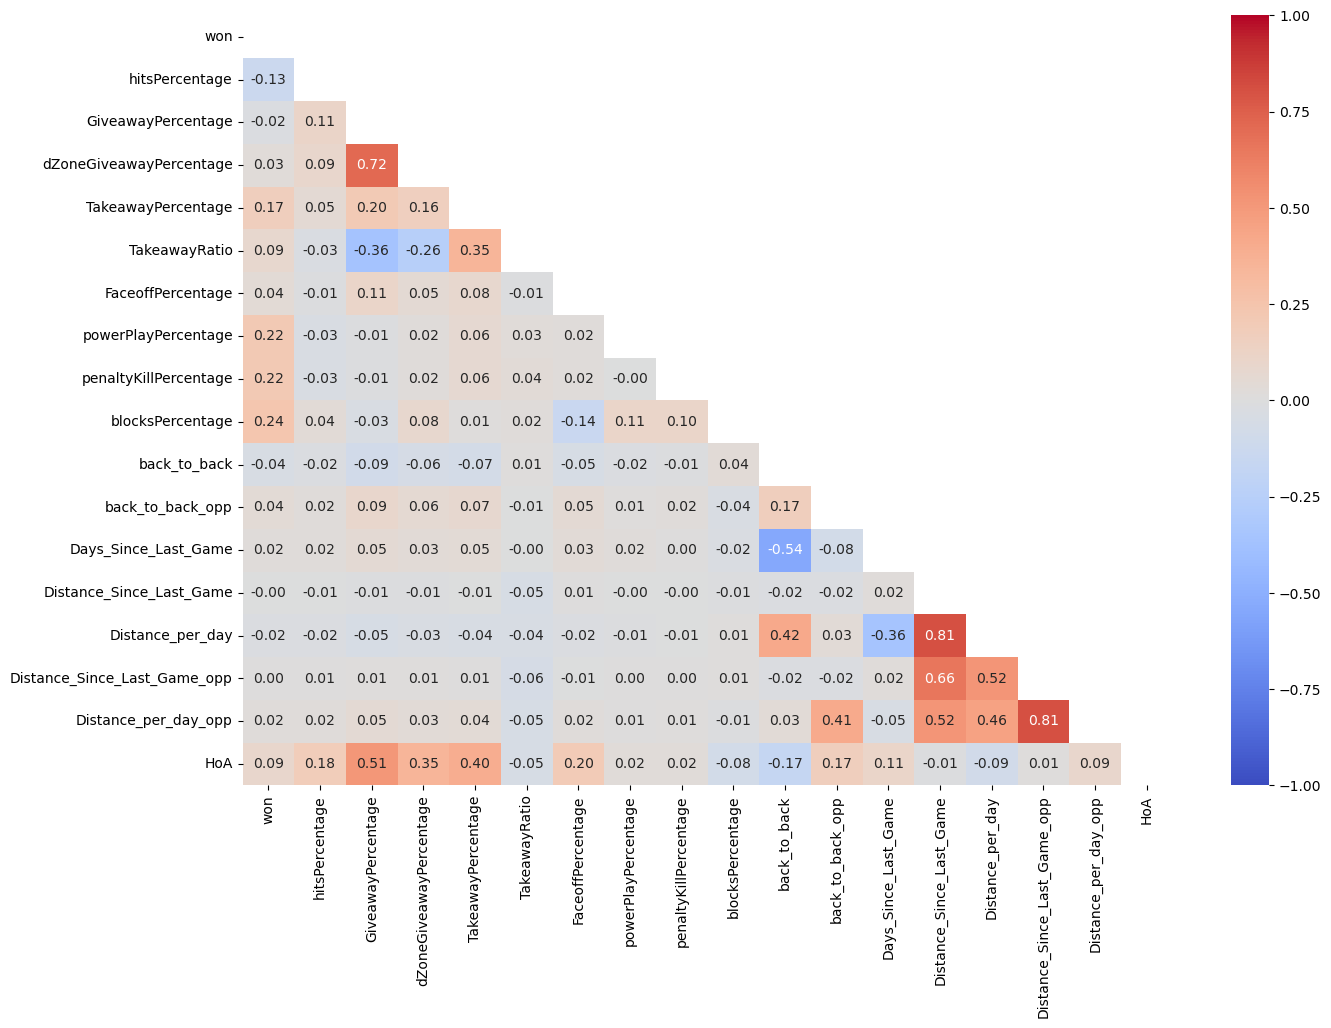

In [99]:
# Create a dataframe including the columns that represent xGoals data
other_columns = engineered_df[['won', 
                               'hitsPercentage', 
                               'GiveawayPercentage', 
                               'dZoneGiveawayPercentage', 
                               'TakeawayPercentage', 
                               'TakeawayRatio', 
                               'FaceoffPercentage', 
                               'powerPlayPercentage', 
                               'penaltyKillPercentage', 
                               'blocksPercentage', 
                               'back_to_back', 
                               'back_to_back_opp', 
                               'Days_Since_Last_Game', 
                               'Distance_Since_Last_Game', 
                               'Distance_per_day', 
                               'Distance_Since_Last_Game_opp',
                               'Distance_per_day_opp',
                               'HoA']]

# Calculate the correlation matrix for the selected columns
correlation_matrix_other = other_columns.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_other, dtype=bool))

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(15, 10)) 
sns.heatmap(correlation_matrix_other, center=0, vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt=".2f", mask=mask)
plt.show()

Some very interesting stuff in there. `hitsPercentage` has an impact on outcome, but it is negative. That is, the team that registers more hits is less likely to win the game. This runs counter to the conventional wisdom that playing 'tougher' than the other team is an effective strategy for winning. We also see that takeaways have a bigger impact on the outcome than giveaways. This suggests that focusing on aggressively trying to get the puck from the other team is a better strategy than focusing on maintaining possession and not giving the puck away. Interestingly, power play effectiveness is more important than penalty killing, which is counterintuitive since they seem like opposite sides of the same coin. As mentioned above, blocks seems to be an important driver of outcome. Together with takeaways, this indicates the importance of playing good defense. We've also included back-to-back games and whether the games are home or away, which are two features that we've already demonstrated are important to determining the outcome.

Based on this analysis, we will include the following variables in initial modeling:

In [48]:
# create other features bucket
other_features = engineered_df[['back_to_back', 
                                'back_to_back_opp',
                                'Distance_per_day', 
                                'HoA', 
                                'hitsPercentage', 
                                'blocksPercentage', 
                                'FaceoffPercentage', 
                                'Days_Since_Last_Game',
                                'powerPlayPercentage',
                                'penaltyKillPercentage',
                                'GiveawayPercentage',
                                'TakeawayPercentage',
                                'TakeawayRatio'
                               ]]

In [330]:
# look at the full dataset with new variables
engineered_df.head(10)

,team_x,season,gameId,opposingTeam,gameDate,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalFor,xGoalsFor,...,hitsPercentage,GiveawayPercentage,dZoneGiveawayPercentage,TakeawayPercentage,TakeawayRatio,FaceoffPercentage,powerPlayPercentage,shorthanded,powerPlayGoalsAgainst,penaltyKillPercentage
0,NYR,2008,2008020001,TBL,2008-10-04,0.4596,0.6408,0.6310,37.733,2.287,...,0.484848,0.533333,0.444444,0.633333,0.703704,0.483871,0.142857,4.0,0.0,1.000000
1,NYR,2008,2008020003,TBL,2008-10-05,0.6619,0.6207,0.6190,34.277,1.793,...,0.243902,0.611111,0.583333,0.600000,0.521739,0.369565,0.250000,5.0,0.0,1.000000
2,NYR,2008,2008020010,CHI,2008-10-10,0.4123,0.4904,0.4643,27.924,1.938,...,0.586667,0.545455,0.666667,0.466667,0.538462,0.418182,0.000000,3.0,0.0,1.000000
3,NYR,2008,2008020019,PHI,2008-10-11,0.5008,0.5000,0.4810,27.100,3.030,...,0.312500,0.272727,0.200000,0.444444,0.571429,0.573529,0.166667,6.0,0.0,1.000000
4,NYR,2008,2008020034,NJD,2008-10-13,0.3114,0.4369,0.4507,21.917,1.562,...,0.462500,0.769231,0.700000,0.590909,0.565217,0.583333,0.500000,3.0,0.0,1.000000
5,NYR,2008,2008020044,BUF,2008-10-15,0.3746,0.6024,0.5714,22.925,1.729,...,0.592593,0.857143,1.000000,0.473684,0.600000,0.540000,0.000000,5.0,2.0,0.600000
6,NYR,2008,2008020057,TOR,2008-10-17,0.7513,0.6387,0.6333,39.302,4.186,...,0.567568,0.818182,0.750000,0.666667,0.608696,0.421053,0.000000,4.0,0.0,1.000000
7,NYR,2008,2008020070,DET,2008-10-18,0.3672,0.3950,0.3800,27.865,2.103,...,0.586957,0.363636,0.428571,0.500000,0.555556,0.517857,0.000000,3.0,1.0,0.666667
8,NYR,2008,2008020079,DAL,2008-10-20,0.5037,0.5566,0.5244,30.267,1.702,...,0.551282,0.777778,0.800000,0.700000,0.666667,0.560976,0.500000,3.0,1.0,0.666667
9,NYR,2008,2008020101,CBJ,2008-10-24,0.5760,0.5370,0.5301,31.380,3.355,...,0.541667,0.555556,0.600000,0.181818,0.285714,0.450980,0.125000,6.0,0.0,1.000000


In [103]:
engineered_df.to_csv('engineered_df_data.csv', index=False)

In [35]:
# look at the info of full dataset
engineered_df.info(135)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35344 entries, 0 to 35343
Data columns (total 135 columns):
 #    Column                                     Dtype  
---   ------                                     -----  
 0    team_x                                     object 
 1    season                                     int64  
 2    gameId                                     int64  
 3    opposingTeam                               object 
 4    gameDate                                   object 
 5    xGoalsPercentage                           float64
 6    corsiPercentage                            float64
 7    fenwickPercentage                          float64
 8    xOnGoalFor                                 float64
 9    xGoalsFor                                  float64
 10   xReboundsFor                               float64
 11   xFreezeFor                                 float64
 12   xPlayStoppedFor                            float64
 13   xPlayContinuedInZoneFor      

Let's look for null values among the new variables.

In [305]:
# Find and count null values in each column
null_counts = engineered_df.isnull().sum()

# Sort columns by the number of null values in descending order
sorted_null_counts = null_counts.sort_values(ascending=False)

# Display the result
sorted_null_counts.head(10)

powerPlayPercentage        620
penaltyKillPercentage      586
highDangerShotsShare       458
dZoneGiveawayPercentage    288
Last_Game_Date              33
TakeawayPercentage          18
GiveawayPercentage          16
TakeawayRatio                9
reboundsAgainst              0
highDangerxGoalsAgainst      0
dtype: int64

This is understandable, because there are cases when the denominator in the share/percentage calculations can be zero, i.e., when a team had no power plays in a game. Let's replace the null values with the mean value for that category, dependent on the value in the `won` column. So, for powerPlayPercentage, we will check to see whether the team won the game, and if so, replace the null value with the average powerPlayPercentage for winning teams, and vice versa. 

In [45]:
# List of columns to process
columns_to_process = [
    'powerPlayPercentage',
    'penaltyKillPercentage',
    'highDangerShotsShare',
    'dZoneGiveawayPercentage',
    'TakeawayPercentage',
    'GiveawayPercentage',
    'TakeawayRatio'
]

# Calculate the mean values for each column based on the 'won' column
mean_values = engineered_df.groupby('won')[columns_to_process].transform('mean')

# Replace the null values in each column based on the 'won' column
for column in columns_to_process:
    engineered_df[column] = engineered_df[column].fillna(mean_values[column])

In [46]:
# Find and count null values in each column
null_counts = engineered_df.isnull().sum()

# Sort columns by the number of null values in descending order
sorted_null_counts = null_counts.sort_values(ascending=False)

# Display the result
sorted_null_counts.head(10)

Last_Game_Date                               33
freezeAgainst                                 0
highDangerGoalsAgainst                        0
scoreAdjustedShotsAttemptsAgainst             0
unblockedShotAttemptsAgainst                  0
scoreAdjustedUnblockedShotAttemptsAgainst     0
dZoneGiveawaysAgainst                         0
xGoalsFromxReboundsOfShotsAgainst             0
xGoalsFromActualReboundsOfShotsAgainst        0
reboundxGoalsAgainst                          0
dtype: int64

Now that we have created new variables and looked for correlations with likelihood of winning, let's run them through a chi-square test to understand if the impact on wins is statistically significant.

In [7]:
import pandas as pd
from scipy.stats import chi2_contingency
from warnings import filterwarnings
filterwarnings('ignore')

# Define the significance level
alpha = 0.05

# Create an empty DataFrame to store the results
results = pd.DataFrame(columns=['Feature', 'Chi-Square', 'P-Value', 'Significant'])

# Iterate through each feature and perform chi-square test
for feature in engineered_df.columns:
    if feature != 'won' and engineered_df[feature].dtype != 'object':
        contingency_table = pd.crosstab(engineered_df[feature], engineered_df['won'])
        chi2, p, _, _ = chi2_contingency(contingency_table)

        significant = p < alpha

        results = results.append({
            'Feature': feature,
            'Chi-Square': round(chi2, 2),
            'P-Value': round(p, 2),
            'Significant': significant
        }, ignore_index=True)

# Set display options to show all rows
pd.set_option('display.max_rows', 10)

# Display the results
results

,Feature,Chi-Square,P-Value,Significant
0,season,0.00,1.00,False
1,gameId,0.00,1.00,False
2,xGoalsPercentage,8330.95,0.00,True
3,corsiPercentage,2771.26,0.00,True
4,fenwickPercentage,1647.92,0.99,False
...,...,...,...,...
134,sum_rolling10_goaldiff_opp,296.36,0.00,True
135,sum_rolling10_goaldiff,296.79,0.00,True
136,shorthanded2,54.11,0.00,True
137,shotEfficiency,18728.98,0.00,True


We want to see the whole list. Let's sort by chi-square value.

In [8]:
# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Sort the results DataFrame on the 'Chi-Square' column from high to low
results = results.sort_values(by='Chi-Square', ascending=False)

results

,Feature,Chi-Square,P-Value,Significant
117,scoreVenuePercentage,35183.53,0.49,False
116,flurryPercentage,35183.33,0.45,False
118,FSVxGoalsPercentage,35162.33,0.50,False
109,goalDifferential,31898.99,0.00,True
91,scoreAdjustedShotsAttemptsAgainst,23427.96,0.21,False
43,scoreAdjustedShotsAttemptsFor,23427.96,0.21,False
93,scoreAdjustedUnblockedShotAttemptsAgainst,21568.09,0.08,False
45,scoreAdjustedUnblockedShotAttemptsFor,21568.09,0.08,False
137,shotEfficiency,18728.98,0.00,True
138,defensiveEfficiency,18594.50,0.00,True


We can also create a dataframe for modeling that includes the specified buckets.

In [49]:
# create df for modeling
model_df = pd.concat([goals_features, shots_features, xGoals_features, other_features], axis=1)

## **Baseline Modeling** <a class="anchor" id="5"></a>

Now that we have identified the initial features that we want to test, we can run some models to understand how effectively the features predict game outcome. We will start by splitting the data into training and test groups. Note that we won't set aside a validation group at this time because we are not yet interested in hyperparameter tuning, we are simply trying to gauge the initial performance of the models.

#### Train and Test Split

In [154]:
from sklearn.model_selection import train_test_split

# Define the features and the target
X = model_df
# X = engineered_df[['HoA', 'sum_rolling10_goals', 'sum_rolling10_goals_opp', 'sum_rolling10_won', 'sum_rolling10_won_opp', 'sum_rolling10_goaldiff', 'sum_rolling10_goaldiff_opp']]  # for playing around with seeing the impact of individual variables on the accuracy
y = engineered_df['won']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
X_train.shape

(28275, 24)

In [39]:
y_train.shape

(28275,)

In [40]:
X_test.shape

(7069, 24)

In [41]:
y_test.shape

(7069,)

#### Normalize the Data

Because we have large numbers like distance mixed with small numbers like percentages, we will normalize the data using a MinMax scaler.

In [155]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
 
# Fit the scaler to the training data and transform
X_train = scaler.fit_transform(X_train)

# Apply the scaler to the test data
X_test = scaler.transform(X_test)

Next we will run a collection of models and see how they perform in terms of accuracy on both the training and test groups.

### Logistic Regression <a class="anchor" id="5a"></a>

In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a logistic regression model
model = LogisticRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = model.predict(X_train)

# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Calculate accuracy on the training data
log_train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test data
log_test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", log_train_accuracy)
print("Test Accuracy:", log_test_accuracy)

Training Accuracy: 0.946631299734748
Test Accuracy: 0.9465270901117555


### Decision Tree <a class="anchor" id="5b"></a>

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create a decision tree model
model = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = model.predict(X_train)

# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Calculate accuracy on the training data
dt_train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test data
dt_test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", dt_train_accuracy)
print("Test Accuracy:", dt_test_accuracy)


Training Accuracy: 1.0
Test Accuracy: 0.939878342056868


### Support Vector Machine <a class="anchor" id="5c"></a>

In [55]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVM classifier
model = SVC(random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = model.predict(X_train)

# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Calculate accuracy on the training data
svm_train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test data
svm_test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", svm_train_accuracy)
print("Test Accuracy:", svm_test_accuracy)

Training Accuracy: 0.9578779840848807
Test Accuracy: 0.951053897298062


### Random Forest <a class="anchor" id="5d"></a>

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest classifier
model = RandomForestClassifier(random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = model.predict(X_train)

# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Calculate accuracy on the training data
rf_train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test data
rf_test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", rf_train_accuracy)
print("Test Accuracy:", rf_test_accuracy)

Training Accuracy: 1.0
Test Accuracy: 0.9496392700523412


### XGBoost <a class="anchor" id="5e"></a>

In [57]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Create an XGBoost classifier
model = XGBClassifier(random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = model.predict(X_train)

# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Calculate accuracy on the training data
xgb_train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test data
xgb_test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", xgb_train_accuracy)
print("Test Accuracy:", xgb_test_accuracy)

Training Accuracy: 0.9998231653404067
Test Accuracy: 0.9531758381666431


In [58]:
# Create an empty datafram to store the metrics
metrics_df = pd.DataFrame(columns=['Training Accuracy', 'Test Accuracy'])

# Add the metrics for the baseline models
metrics_df.loc['Logistic Regression'] = [log_train_accuracy, log_test_accuracy]
metrics_df.loc['Decision Tree'] = [dt_train_accuracy, dt_test_accuracy]
metrics_df.loc['SVM'] = [svm_train_accuracy, svm_test_accuracy]
metrics_df.loc['Random Forest'] = [rf_train_accuracy, rf_test_accuracy]
metrics_df.loc['XGBoost'] = [xgb_train_accuracy, xgb_test_accuracy]

# Print the comparison table
metrics_df

,Training Accuracy,Test Accuracy
Logistic Regression,0.946631,0.946527
Decision Tree,1.000000,0.939878
SVM,0.957878,0.951054
Random Forest,1.000000,0.949639
XGBoost,0.999823,0.953176


Let's create a graph comparing the performance.

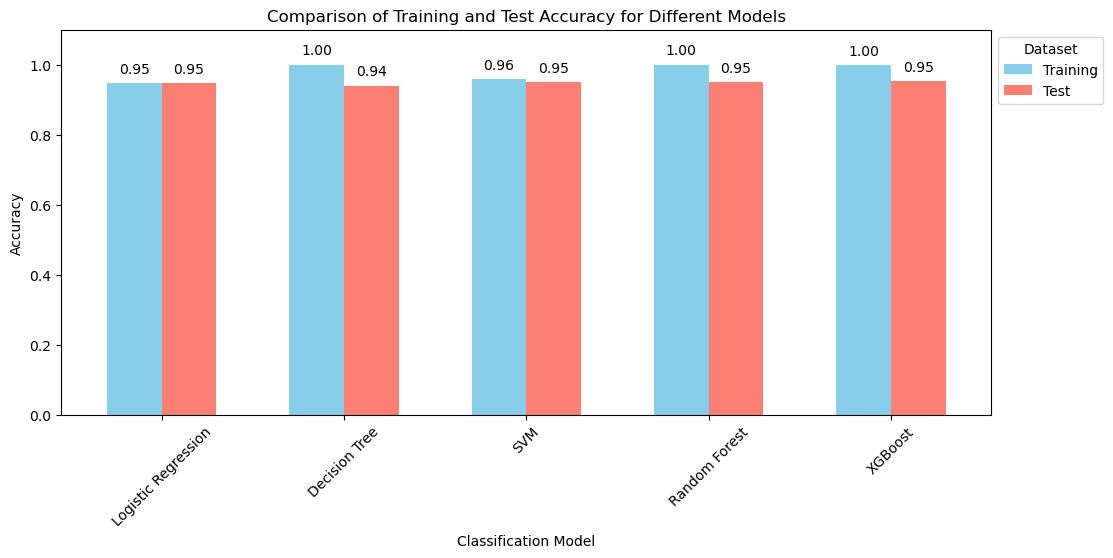

In [174]:
# Create a dataframe from the data
metrics_df = pd.DataFrame(data)

# Set the index to 'Classification Model'
metrics_df.set_index('Classification Model', inplace=True)

# Plot the bar graph with wider bars and values on top
ax = metrics_df.plot(kind='bar', figsize=(12, 5), color=['skyblue', 'salmon'], width=0.6)

plt.title('Comparison of Training and Test Accuracy for Different Models')
plt.xlabel('Classification Model')
plt.ylabel('Accuracy')

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

# Move the legend outside of the graph
plt.legend(title='Dataset', labels=['Training', 'Test'], loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the y-axis limit
ax.set_ylim(top=1.1)

plt.xticks(rotation=45)

plt.show()

Well that's terrific. With this limited set of features, and with no hyperparameter tuning, we can accurately predict the results of 95%+ games! 

Unfortunately, it's almost completely useless for predicting actual future game outcomes. This is not a credit card application or a medical imaging problem where we can feed the model the input variables and have it calculate the expected future outcome. Most of these input variables happen *during* the event that we need to predict. Put another way, if we feed these models all of the in-game data from a completed game, it can predict the winner of that game with high accuracy, but we already know the winner of that game.

This is not to say that there aren't some useful insights to be gleaned from this exercise. We can look at the impact that each of the variables had on the outcome and draw some conclusions about the characteristics of successful teams. This could be useful to team management in optimizing the construction of rosters to maximize success.

One way to measure this is to compare the model performance when we add one variable to the baseline model performance with a single variable. That single variable? `HoA`, which indicates whether the team is playing at home or on the road. As we established above, the home team wins ~54% of games, and it turns out that running a regression with only `HoA` as the X variable gives an accuracy of ~54%. The model can pick the home team to win each game, and it will be correct 54% of the time. 

We can create a for loop to systematically add a second variable to X from the model_df variables, run through each of them, and compare the results to see which added the most to accuracy.

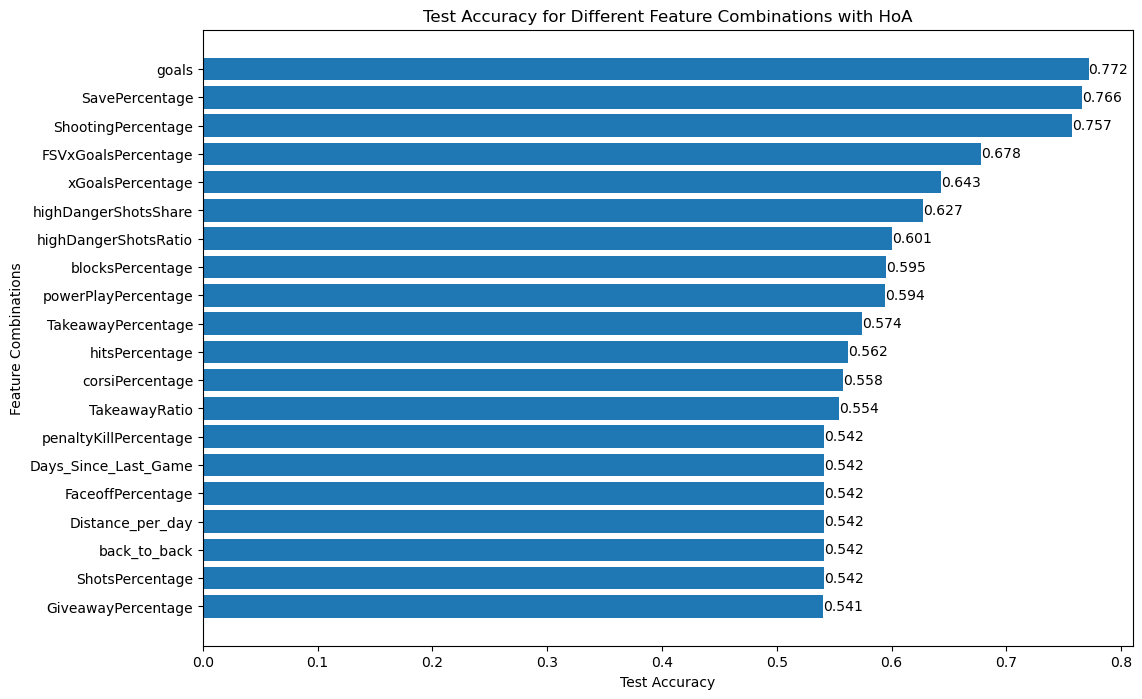

In [403]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the features and the target
X = model_df
y = engineered_df['won']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a scaler
scaler = MinMaxScaler()

# Create a dictionary to store the test accuracies
test_accuracies = {}

# Iterate through each feature in X
for feature in X.columns:
    if feature == 'HoA':
        continue  # Skip 'HoA' itself
    
    # Create the feature subset including 'HoA' and the current feature
    X_train_subset = X_train[['HoA', feature]]
    X_test_subset = X_test[['HoA', feature]]
    
    # Apply the scaler to the training and test subsets
    X_train_scaled = scaler.fit_transform(X_train_subset)
    X_test_scaled = scaler.transform(X_test_subset)
    
    # Create a logistic regression model
    model = LogisticRegression()
    
    # Fit the model on the training data
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on the test data
    y_test_pred = model.predict(X_test_scaled)
    
    # Calculate accuracy on the test data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Store the test accuracy in the dictionary
    test_accuracies[feature] = test_accuracy

# Sort the test accuracies in ascending order
sorted_accuracies = dict(sorted(test_accuracies.items(), key=lambda item: item[1]))

# Extract feature names and test accuracies
feature_names = list(sorted_accuracies.keys())
accuracies = list(sorted_accuracies.values())

# Create a bar graph showing the test accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(feature_names, accuracies)
plt.xlabel('Test Accuracy')
plt.ylabel('Feature Combinations')
plt.title('Test Accuracy for Different Feature Combinations with HoA')
plt.xticks(rotation=0)

# Add value labels to the bars
for i, v in enumerate(accuracies):
    plt.text(v, i, f'{v:.3f}', va='center')

plt.show()


We can see from the above that adding `goals` to `HoA` gives the highest increase in accuracy. With just those two variables, a model can accurately predict 77% of the results. We get similar results adding in `ShootingPercentage` and `SavePercentage`. Teams that score on a lot of their shots are more likely to win, and teams that stop a lot of the other team's shots are more likely to win. Next on the list are expected goals and high danger shots/chances. These are more about creating opportunities to score, rather than actually scoring. We also have some more defensive drivers of outcome, like blocked shots and takeaways. We could flesh out this information in much greater detail, looking at many more individual and team statistics, and this would be helpful to teams in finding the types of players that are most likely to contribute to success. This could be a future phase of this analysis.

What we really want, however, is the ability to predict the game outcome before it has been played! In order to do this, we can only use variables that we have prior to the game being played. There are a limited number of such features in our dataset currently. As we have discussed, whether the game is being played at home or on the road is the most important one. The others include `Days_Since_Last_Game`, `Distance_Since_Last_Game`, `Distance_per_day`, and `back_to_back`, i.e., whether the team played the day before. Unfortunately, those additional features do very little to move the needle, based on the regression graph above. We will need to develop another solution to this problem.

## **Refinements (and More Feature Engineering...)** <a class="anchor" id="6"></a>

As we mentioned above, we need information from before the game to help in predicting the outcome. Fortunately, we do have a lot of information from before the game. Every game that happened prior to the current game can be used for modeling. Specifically, we can create variables that look at the performance of both teams in a game over the prior x games, and use that as an input. How many games we should include, and whether we should be using weighting to adjust the importance of more recent games is an open question at this point. For now, we will start creating some features that aggregate results from the prior 10 games, and see what kind of value we can get from those. We will pick some of the variables that have the highest in-game impact on outcome, and see if those correlations hold for previous games.

In [ ]:
#create 10 game goal variable
engineered_df['sum_rolling10_goals'] = engineered_df.groupby('team_x')['goals'].transform(lambda x: x.rolling(10, 0).sum().shift())

In [63]:
# replace first game for each team in the dataset value with 0
engineered_df['sum_rolling10_goals'].fillna(0, inplace=True)

In [67]:
# Create a dictionary to map opponents rolling 10 game goal total
rolling_10_goals_opp_dict = engineered_df.apply(
    lambda row: engineered_df[
        (engineered_df['gameId'] == row['gameId']) &
        (engineered_df['team_x'] == row['opposingTeam'])
    ]['sum_rolling10_goals'].values[0],
    axis=1
)

# Assign the 'sum_rolling10_goals_opp' column based on the dictionary
engineered_df['sum_rolling10_goals_opp'] = rolling_10_goals_opp_dict

In [ ]:
# variable on wins over past 10 games
engineered_df['sum_rolling10_won'] = engineered_df.groupby('team_x')['won'].transform(lambda x: x.rolling(10, 0).sum().shift())

In [ ]:
# Create a dictionary to map opponents rolling 10 game goal total
rolling_10_won_opp_dict = engineered_df.apply(
    lambda row: engineered_df[
        (engineered_df['gameId'] == row['gameId']) &
        (engineered_df['team_x'] == row['opposingTeam'])
    ]['sum_rolling10_won'].values[0],
    axis=1
)

# Assign the 'sum_rolling10_won_opp' column based on the dictionary
engineered_df['sum_rolling10_won_opp'] = rolling_10_won_opp_dict

In [ ]:
# variable on goal differential over past 10 games
engineered_df['sum_rolling10_goaldiff'] = engineered_df.groupby('team_x')['goalDifferential'].transform(lambda x: x.rolling(10, 0).sum().shift())

In [124]:
# Create a dictionary to map opponents rolling 10 game goal total
rolling_10_goalpercent_dict = engineered_df.apply(
    lambda row: engineered_df[
        (engineered_df['gameId'] == row['gameId']) &
        (engineered_df['team_x'] == row['opposingTeam'])
    ]['sum_rolling10_goalPercentage'].values[0],
    axis=1
)

# Assign the 'sum_rollidiffg10_gPercentageals_opp' column based on the dictionary
engineered_df['sum_rolling10_goalPercentage_opp'] = rolling_10_goalpercent_dict

In [ ]:
# variable on goal percentage over the past 10 games
engineered_df['sum_rolling10_goalPercentage'] = engineered_df.groupby('team_x')['goalPercentage'].transform(lambda x: x.rolling(10, 0).sum().shift())

In [149]:
# replace first game for each team in the dataset value with 0
engineered_df['sum_rolling10_goalPercentage_opp'].fillna(0, inplace=True)

In [124]:
# Create a dictionary to map opponents rolling 10 game goal total
rolling_10_goalpercent_dict = engineered_df.apply(
    lambda row: engineered_df[
        (engineered_df['gameId'] == row['gameId']) &
        (engineered_df['team_x'] == row['opposingTeam'])
    ]['sum_rolling10_goalPercentage'].values[0],
    axis=1
)

# Assign the 'sum_rollidiffg10_gPercentageals_opp' column based on the dictionary
engineered_df['sum_rolling10_goalPercentage_opp'] = rolling_10_goalpercent_dict

In [149]:
# replace first game for each team in the dataset value with 0
engineered_df['sum_rolling10_goalPercentage_opp'].fillna(0, inplace=True)

In [ ]:
# take a look at the variables we have created
engineered_df.tail()

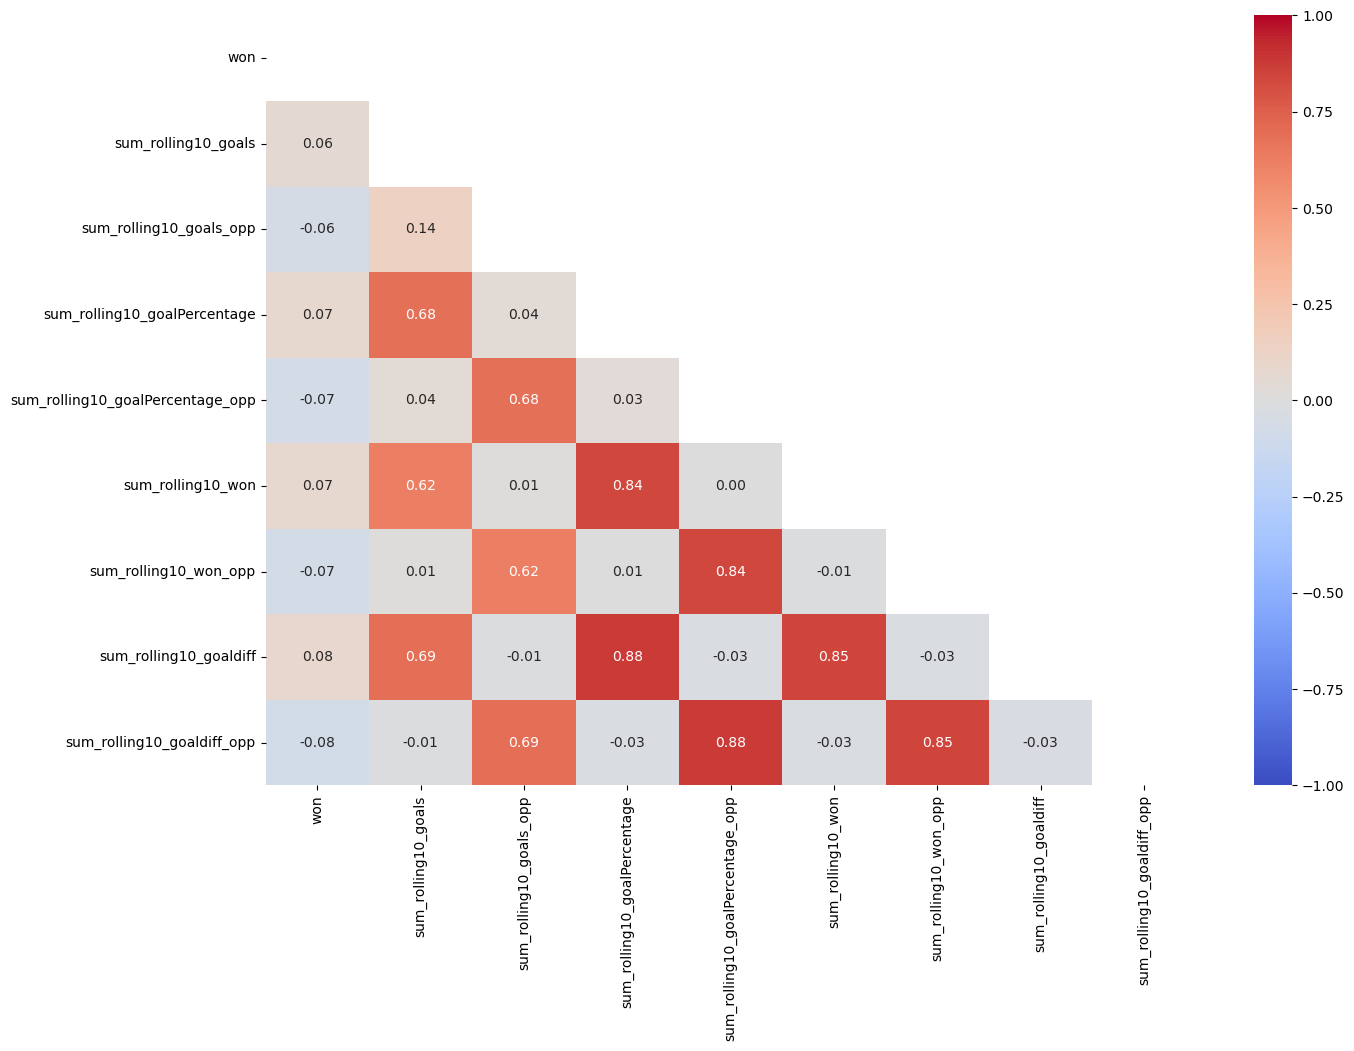

In [125]:
# Create a dataframe including the columns that represent xGoals data
other_columns = engineered_df[['won', 'sum_rolling10_goals', 'sum_rolling10_goals_opp', 'sum_rolling10_goalPercentage', 'sum_rolling10_goalPercentage_opp', 'sum_rolling10_won', 'sum_rolling10_won_opp', 'sum_rolling10_goaldiff', 'sum_rolling10_goaldiff_opp']]

# Calculate the correlation matrix for the selected columns
correlation_matrix_other = other_columns.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_other, dtype=bool))

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(15, 10)) 
sns.heatmap(correlation_matrix_other, center=0, vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt=".2f", mask=mask)
plt.show()

Well, creating each of those variables individually is not scalable. I will go through the dataset and determine which variables I would like to create this way, then write some code to do it programmatically.

In [91]:
# List of columns to process
columns_to_process = [
    'xGoalsFor',
    'flurryAdjustedxGoalsFor',
    'scoreVenueAdjustedxGoalsFor',
    'flurryScoreVenueAdjustedxGoalsFor',
    'shotsOnGoalFor',
    'shotAttemptsFor',
    'savedShotsOnGoalFor',
    'faceOffsWonFor',
    'hitsFor',
    'takeawaysFor',
    'giveawaysFor',
    'highDangerShotsFor',
    'highDangerxGoalsFor',
    'xGoalsFromxReboundsOfShotsFor',
    'xGoalsFromActualReboundsOfShotsFor',
    'xGoalsAgainst',
    'flurryAdjustedxGoalsAgainst',
    'scoreVenueAdjustedxGoalsAgainst',
    'flurryScoreVenueAdjustedxGoalsAgainst',
    'shotsOnGoalAgainst',
    'shotAttemptsAgainst',
    'goalsAgainst',
    'savedShotsOnGoalAgainst',
    'faceOffsWonAgainst',
    'hitsAgainst',
    'takeawaysAgainst',
    'giveawaysAgainst',
    'highDangerShotsAgainst',
    'highDangerxGoalsAgainst',
    'xGoalsFromxReboundsOfShotsAgainst',
    'xGoalsFromActualReboundsOfShotsAgainst'
]

for column in columns_to_process:
    new_column_name = f'sum_rolling10_{column}'
    engineered_df[new_column_name] = engineered_df.groupby('team_x')[column].transform(lambda x: x.rolling(10, 0).sum().shift())
    engineered_df[new_column_name].fillna(0, inplace=True)

In [92]:
# List of columns to process
columns_to_process = [
    'xGoalsPercentage',
    'corsiPercentage',
    'fenwickPercentage',
    'ShotsPercentage',
    'highDangerShotsShare',
    'highDangerShotsRatio',
    'ShootingPercentage',
    'SavePercentage',
    'blocksPercentage',
    'flurryPercentage',
    'scoreVenuePercentage',
    'FSVxGoalsPercentage',
    'hitsPercentage',
    'GiveawayPercentage',
    'dZoneGiveawayPercentage',
    'TakeawayPercentage',
    'TakeawayRatio',
    'FaceoffPercentage',
    'powerPlayPercentage',
    'penaltyKillPercentage',
    'shotEfficiency',
    'defensiveEfficiency'
]

for column in columns_to_process:
    new_column_name = f'mean_rolling10_{column}'
    engineered_df[new_column_name] = engineered_df.groupby('team_x')[column].transform(lambda x: x.rolling(10, 0).mean().shift())
    engineered_df[new_column_name].fillna(0, inplace=True)

In [96]:
# List of columns to process
columns_to_process = [
    'sum_rolling10_goals',
    'sum_rolling10_won',
    'sum_rolling10_goaldiff',
    'sum_rolling10_xGoalsFor',
    'sum_rolling10_flurryAdjustedxGoalsFor',
    'sum_rolling10_scoreVenueAdjustedxGoalsFor',
    'sum_rolling10_flurryScoreVenueAdjustedxGoalsFor',
    'sum_rolling10_shotsOnGoalFor',
    'sum_rolling10_shotAttemptsFor',
    'sum_rolling10_savedShotsOnGoalFor',
    'sum_rolling10_faceOffsWonFor',
    'sum_rolling10_hitsFor',
    'sum_rolling10_takeawaysFor',
    'sum_rolling10_giveawaysFor',
    'sum_rolling10_highDangerShotsFor',
    'sum_rolling10_highDangerxGoalsFor',
    'sum_rolling10_xGoalsFromxReboundsOfShotsFor',
    'sum_rolling10_xGoalsFromActualReboundsOfShotsFor',
    'sum_rolling10_xGoalsAgainst',
    'sum_rolling10_flurryAdjustedxGoalsAgainst',
    'sum_rolling10_scoreVenueAdjustedxGoalsAgainst',
    'sum_rolling10_flurryScoreVenueAdjustedxGoalsAgainst',
    'sum_rolling10_shotsOnGoalAgainst',
    'sum_rolling10_shotAttemptsAgainst',
    'sum_rolling10_goalsAgainst',
    'sum_rolling10_savedShotsOnGoalAgainst',
    'sum_rolling10_faceOffsWonAgainst',
    'sum_rolling10_hitsAgainst',
    'sum_rolling10_takeawaysAgainst',
    'sum_rolling10_giveawaysAgainst',
    'sum_rolling10_highDangerShotsAgainst',
    'sum_rolling10_highDangerxGoalsAgainst',
    'sum_rolling10_xGoalsFromxReboundsOfShotsAgainst',
    'sum_rolling10_xGoalsFromActualReboundsOfShotsAgainst',
    'mean_rolling10_xGoalsPercentage',
    'mean_rolling10_corsiPercentage',
    'mean_rolling10_fenwickPercentage',
    'mean_rolling10_ShotsPercentage',
    'mean_rolling10_highDangerShotsShare',
    'mean_rolling10_highDangerShotsRatio',
    'mean_rolling10_ShootingPercentage',
    'mean_rolling10_SavePercentage',
    'mean_rolling10_blocksPercentage',
    'mean_rolling10_flurryPercentage',
    'mean_rolling10_scoreVenuePercentage',
    'mean_rolling10_FSVxGoalsPercentage',
    'mean_rolling10_hitsPercentage',
    'mean_rolling10_GiveawayPercentage',
    'mean_rolling10_dZoneGiveawayPercentage',
    'mean_rolling10_TakeawayPercentage',
    'mean_rolling10_TakeawayRatio',
    'mean_rolling10_FaceoffPercentage',
    'mean_rolling10_powerPlayPercentage',
    'mean_rolling10_penaltyKillPercentage',
    'mean_rolling10_shotEfficiency',
    'mean_rolling10_defensiveEfficiency',
]

for column in columns_to_process:
    new_column_name = f'{column}_opp'
    opp_dict = engineered_df.apply(
        lambda row: engineered_df[
            (engineered_df['gameId'] == row['gameId']) &
            (engineered_df['team_x'] == row['opposingTeam'])
        ][column].values[0],
        axis=1
    )
    engineered_df[new_column_name] = opp_dict

In [133]:
engineered_df.to_csv('engineered_df_data4.csv', index=False)

In [3]:
engineered_df = pd.read_csv('engineered_df_data4.csv')

In [111]:
engineered_df.shape

(35344, 252)

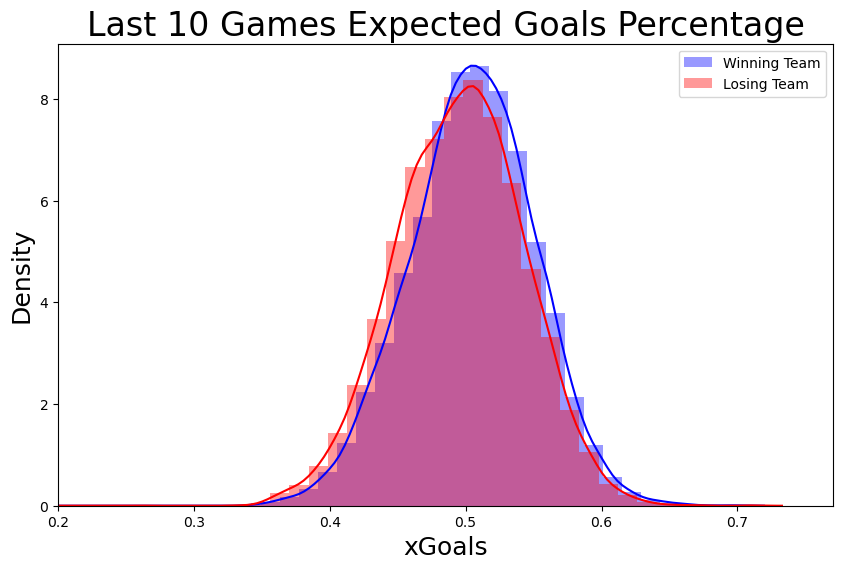

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for 'won' column equal to 1
won_team = engineered_df[engineered_df['won'] == 1]
# Filter data for 'won' column equal to 0
lost_team = engineered_df[engineered_df['won'] == 0]

fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.distplot(won_team['mean_rolling10_xGoalsPercentage'], color='blue', label='Winning Team')
ax = sns.distplot(lost_team['mean_rolling10_xGoalsPercentage'], color='red', label='Losing Team')

ax.set_title('Last 10 Games Expected Goals Percentage', fontsize=24)
ax.set_xlabel('xGoals', fontsize=18)
ax.set_ylabel('Density', fontsize=18)
ax.legend(loc='upper right')

# Set a specific range for the x-axis (exclude 0)
ax.set_xlim(left=0.2, right=None)

plt.show()

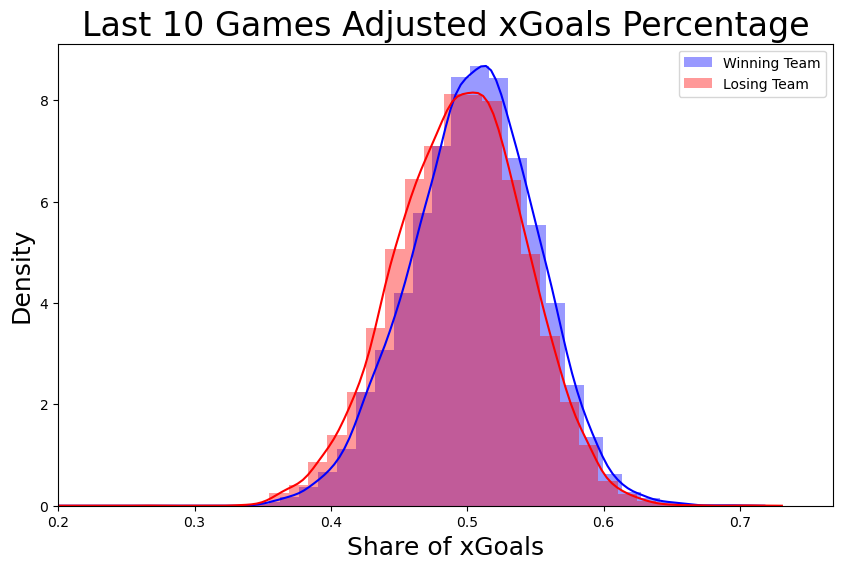

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for 'won' column equal to 1
won_team = engineered_df[engineered_df['won'] == 1]
# Filter data for 'won' column equal to 0
lost_team = engineered_df[engineered_df['won'] == 0]

fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.distplot(won_team['mean_rolling10_FSVxGoalsPercentage'], color='blue', label='Winning Team')
ax = sns.distplot(lost_team['mean_rolling10_FSVxGoalsPercentage'], color='red', label='Losing Team')

ax.set_title('Last 10 Games Adjusted xGoals Percentage', fontsize=24)
ax.set_xlabel('Share of xGoals', fontsize=18)
ax.set_ylabel('Density', fontsize=18)
ax.legend(loc='upper right')

# Set a specific range for the x-axis (exclude 0)
ax.set_xlim(left=0.2, right=None)

plt.show()

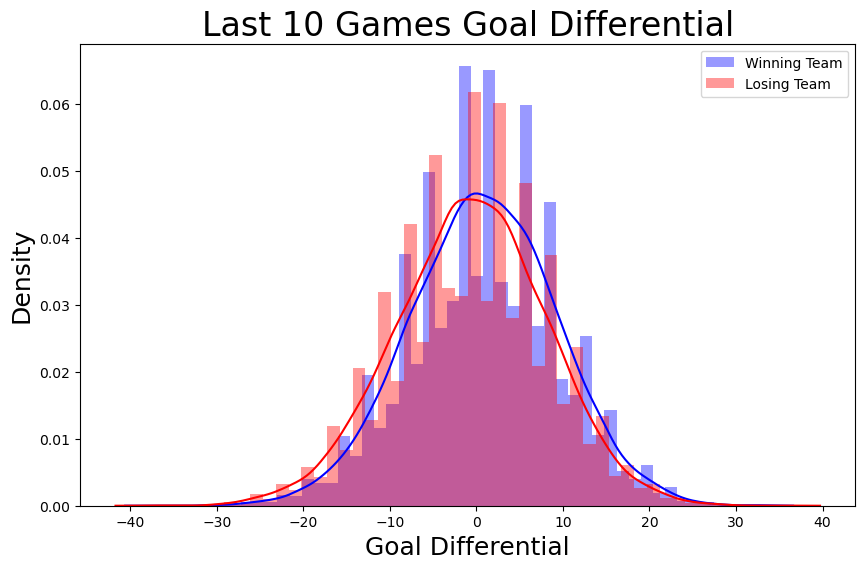

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for 'won' column equal to 1
won_team = engineered_df[engineered_df['won'] == 1]
# Filter data for 'won' column equal to 0
lost_team = engineered_df[engineered_df['won'] == 0]

fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.distplot(won_team['sum_rolling10_giff'], color='blue', label='Winning Team')
ax = sns.distplot(lost_team['sum_rolling10_goaldiff'], c='red', label='Losing Team')

ax.set_title('Last 10 Games Goal Differential', fontsize=24)
ax.set_xlabel('Goal Differential', fontsize=18)
ax.set_ylabel('Density', fontsize=18)
ax.legend(loc='upper right')

plt.show()

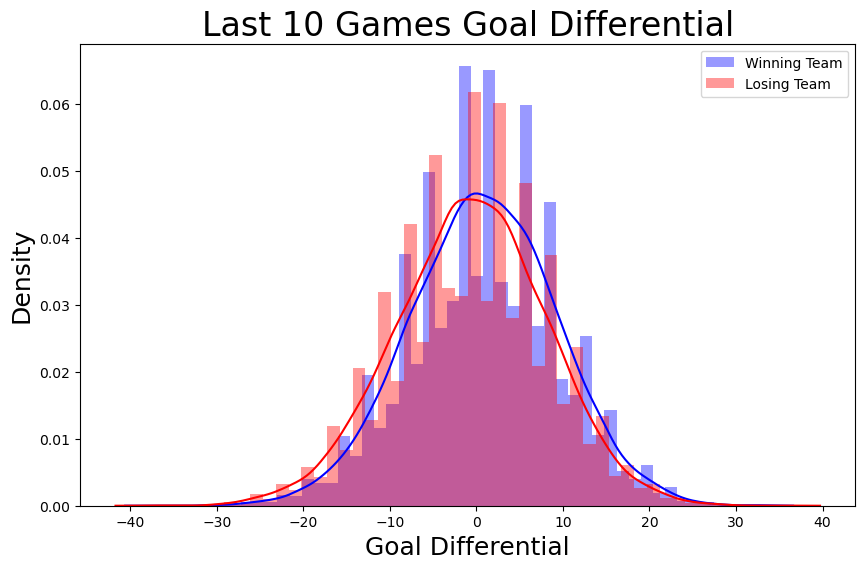

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for 'won' column equal to 1
won_team = engineered_df[engineered_df['won'] == 1]
# Filter data for 'won' column equal to 0
lost_team = engineered_df[engineered_df['won'] == 0]

fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.distplot(won_team['sum_rolling10_giff'], color='blue', label='Winning Team')
ax = sns.distplot(lost_team['sum_rolling10_goaldiff'], c='red', label='Losing Team')

ax.set_title('Last 10 Games Goal Differential', fontsize=24)
ax.set_xlabel('Goal Differential', fontsize=18)
ax.set_ylabel('Density', fontsize=18)
ax.legend(loc='upper right')

plt.show()

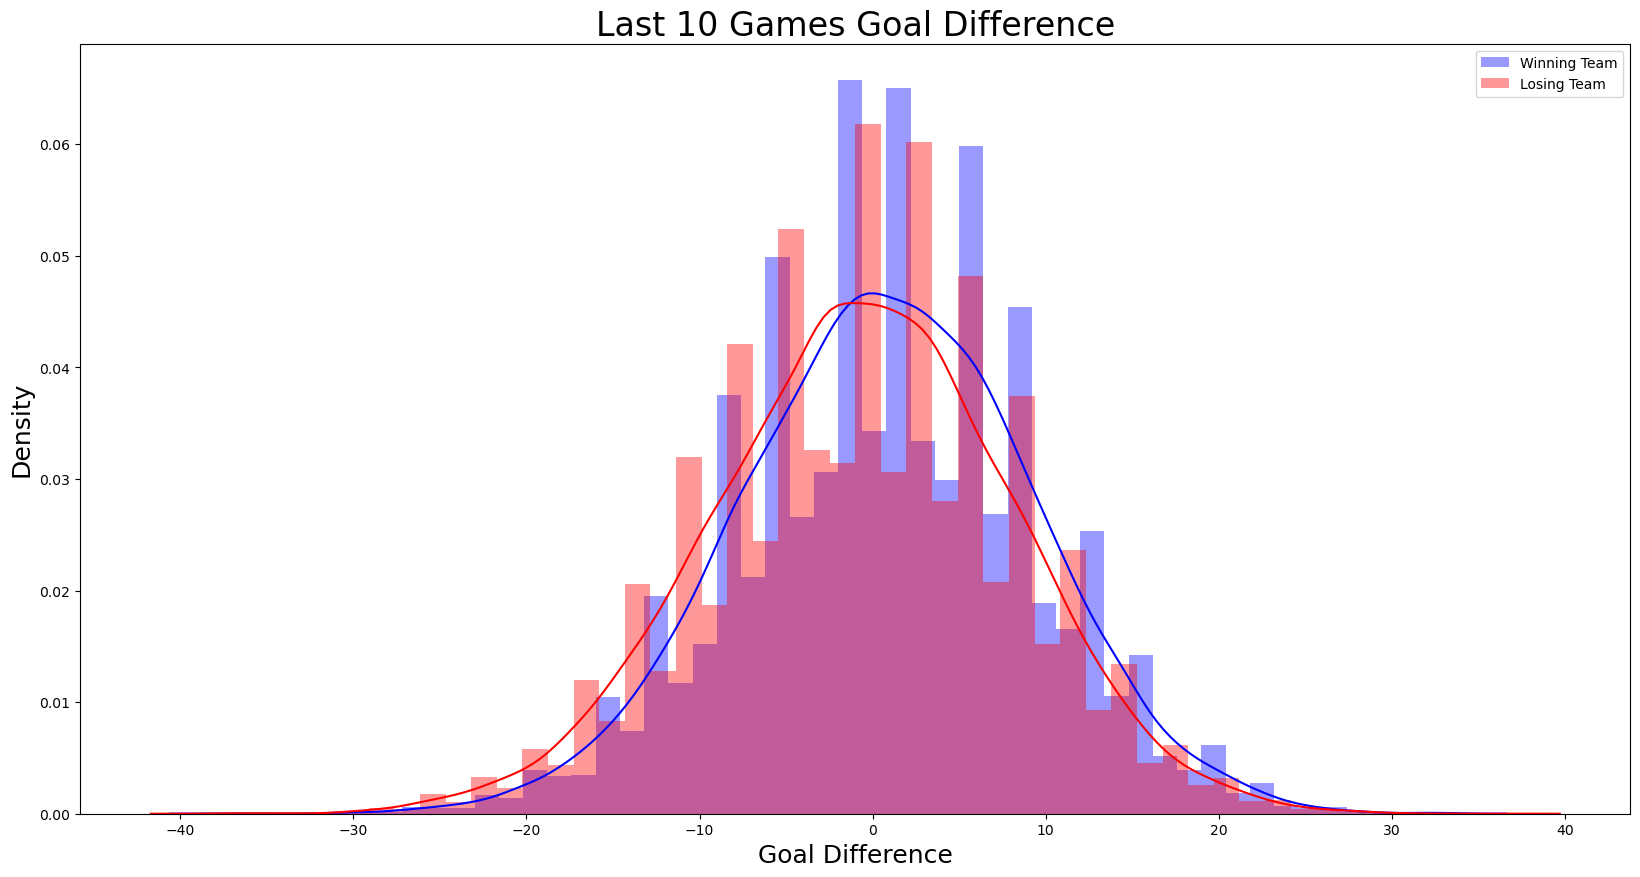

In [8]:
# Filter data for 'won' column equal to 1
won_team = engineered_df[engineered_df['won'] == 1]
# Filter data for 'won' column equal to 0
lost_team = engineered_df[engineered_df['won'] == 0]

fig, ax = plt.subplots(figsize=(20, 10))

ax = sns.distplot(won_team['sum_rolling10_goaldiff'], color='blue', label='Winning Team')
ax = sns.distplot(lost_team['sum_rolling10_goaldiff'], color='red', label='Losing Team')

ax.set_title('Last 10 Games Goal Difference', fontsize=24)
ax.set_xlabel('Goal Difference', fontsize=18)
ax.set_ylabel('Density', fontsize=18)
ax.legend(loc='upper right')

plt.show()

In [131]:
correlations = engineered_df.corr()['won'].sort_values(ascending=False)[1:]
pd.options.display.float_format = '{:.6f}'.format
print(correlations)

goalDifferential                                            0.823009
goalPercentage                                              0.806700
goals                                                       0.600189
goalsFor                                                    0.596068
ShootingPercentage                                          0.573269
SavePercentage                                              0.570547
shotEfficiency                                              0.479932
FSVxGoalsPercentage                                         0.410682
scoreVenuePercentage                                        0.392303
flurryPercentage                                            0.355723
mediumDangerGoalsFor                                        0.350174
highDangerGoalsFor                                          0.341612
xGoalsPercentage                                            0.338433
lowDangerGoalsFor                                           0.315505
flurryScoreVenueAdjustedxGoalsFor 

Let's create a dataframe that contains only those variables that we know before the game starts.

In [150]:
# create dataframe
selected_columns = [col for col in engineered_df.columns if col.startswith('mean_') or col.startswith('sum_')]

selected_columns.extend([
    'HoA', 'Days_Since_Last_Game', 'back_to_back',
    'Distance_Since_Last_Game', 'Distance_per_day'
])

pregame_df = engineered_df[selected_columns]


Let's graph the top 20 variables with the highest positive and negative correlations with winning.

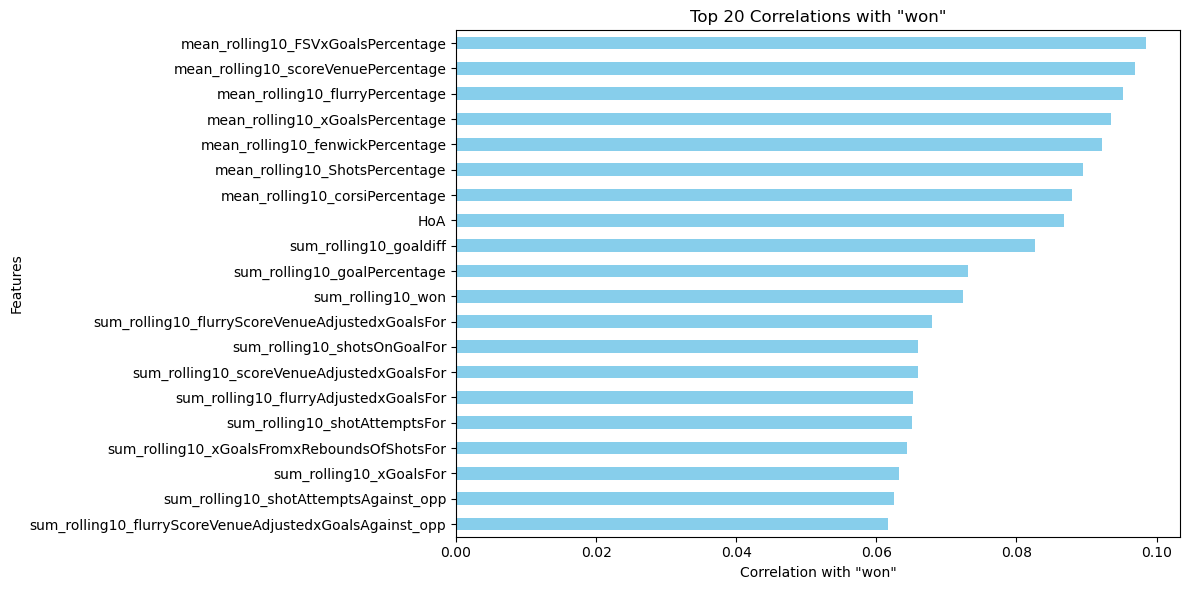

In [161]:
# Calculate correlations with the 'won' column for pregame_df
correlations = pregame_df.corrwith(engineered_df['won']).sort_values(ascending=False)
top_20_correlations = correlations.head(20)

# Reverse the order of correlations to show the highest value at the top
top_20_correlations = top_20_correlations[::-1]

# Create a horizontal bar plot for the top 20 correlations
plt.figure(figsize=(12, 6))
top_20_correlations.plot(kind='barh', color='skyblue')

# Set labels and title
plt.xlabel('Correlation with "won"')
plt.ylabel('Features')
plt.title('Top 20 Correlations with "won"')

# Show the plot
plt.tight_layout()
plt.show()

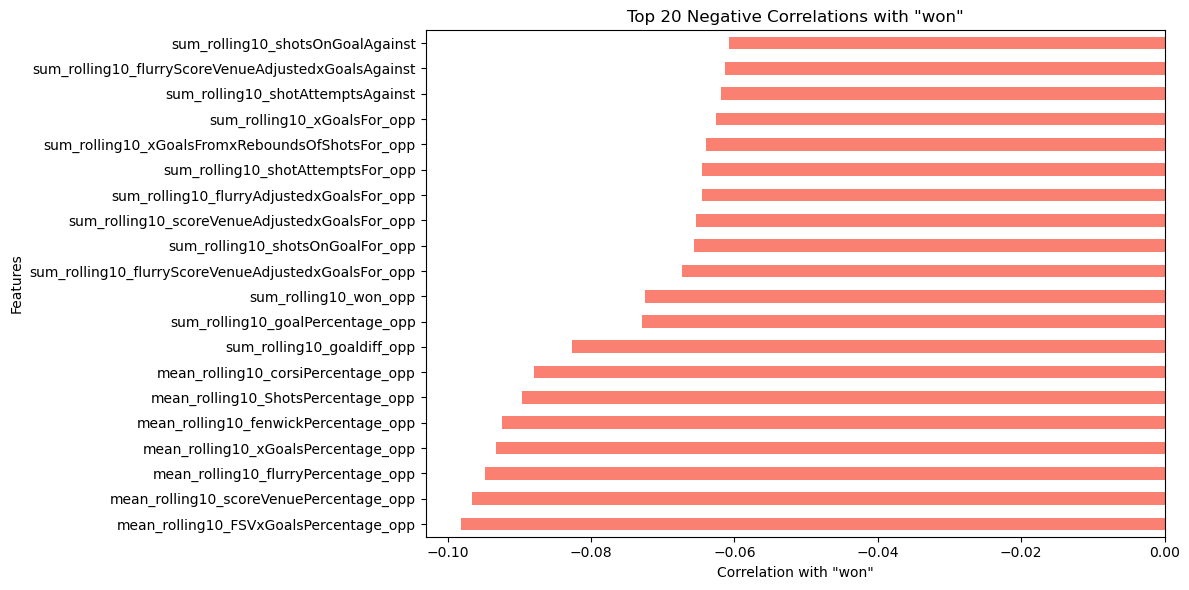

In [162]:
# Calculate correlations with the 'won' column for pregame_df
correlations = pregame_df.corrwith(engineered_df['won']).sort_values(ascending=True)
top_20_correlations = correlations.head(20)

# Create a horizontal bar plot for the top 20 negative correlations
plt.figure(figsize=(12, 6))
top_20_correlations.plot(kind='barh', color='salmon')

# Set labels and title
plt.xlabel('Correlation with "won"')
plt.ylabel('Features')
plt.title('Top 20 Negative Correlations with "won"')

# Show the plot
plt.tight_layout()
plt.show()

Not surprisingly, the correlations of these pregame variables with outcome are significantly lower than some of the in-game variables. For example, `goals` has a correlation of ~0.6 with wins, while the highest value among these variables in ~0.1. It's encouraging at least that some have higher correlation than `HoA` (home or away), which we know has an impact on outcome. We can proceed with some test modeling with these new variables, but we will also keep in mind that there is some potential for adjusting the way the pregame variables are calculated. The number of games to include and whether there should be any weighting for recency should be considered as we tune the variables going forward, in addition to the models.

## **Next Steps** <a class="anchor" id="7"></a>